<a href="https://colab.research.google.com/github/IslamBabou/CS-debut----student-management-/blob/main/LABR_Recomendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Travail realisé par:
#                 Islam Babouhoun
#                 Lotfi Korfe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [ ]:
# ============================================
# CELL 1: IMPORT AND PREPROCESS
# ============================================



# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
RANDOM_STATE = 42

print("=" * 60)
print("LOADING AND PREPROCESSING DATA")
print("=" * 60)

# Load data
df = pd.read_csv("reviews.tsv", sep="\t", header=None)
df = df.sample(frac=1, random_state=RANDOM_STATE)
df.columns = ["rating", "review_id", "user_id", "book_id", "review"]

print(f"\n✓ Loaded {len(df):,} rows")
print(f"Shape: {df.shape}")
print("\nFirst 3 rows:")
print(df.head(3))

# Check for missing values
print("\n" + "-" * 60)
print("Missing Values:")
print(df.isnull().sum())

# Remove missing reviews
initial_count = len(df)
df = df.dropna(subset=['review'])
print(f"\n✓ Removed {initial_count - len(df)} rows with missing reviews")

# Remove duplicates
before_dup = len(df)
df = df.drop_duplicates(subset=['user_id', 'book_id', 'review'], keep='first')

# Remove multiple reviews by the same user for the same book

df = df.drop_duplicates(subset=['user_id', 'book_id'], keep='first')


print(f"✓ Removed {before_dup - len(df)} duplicate reviews")

# Calculate initial metrics
df['review_length'] = df['review'].astype(str).apply(len)

# Display statistics
print("\n" + "-" * 60)
print("DATASET STATISTICS:")
print("-" * 60)
print(f"Total reviews: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique books: {df['book_id'].nunique():,}")
print(f"Avg rating: {df['rating'].mean():.2f}")
print(f"Avg review length: {df['review_length'].mean():.1f} characters")

# Rating distribution
print("\nRating Distribution:")
rating_dist = df['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    pct = count / len(df) * 100
    print(f"  {rating} stars: {count:6,} ({pct:5.2f}%)")

print("\n✓ Preprocessing complete!")

LOADING AND PREPROCESSING DATA

✓ Loaded 63,257 rows
Shape: (63257, 5)

First 3 rows:
       rating  review_id  user_id  book_id  \
48973       4   94005367  2254194  6774781   
21484       5  298282600  7588505  3127736   
43970       5  192015457  4004303  3294671   

                                                  review  
48973   مجموعة من المقالات المجمعة التى نشرت فى عدة ص...  
21484   بدأتها البارحة وانتهيت منها صُبح اليوم خمسون ...  
43970   رواية رائعه . تحكي قصة غُلب المرض وضعف الحيلة...  

------------------------------------------------------------
Missing Values:
rating       0
review_id    0
user_id      0
book_id      0
review       0
dtype: int64

✓ Removed 0 rows with missing reviews
✓ Removed 3105 duplicate reviews

------------------------------------------------------------
DATASET STATISTICS:
------------------------------------------------------------
Total reviews: 60,152
Unique users: 16,486
Unique books: 2,131
Avg rating: 3.87
Avg review length: 341.6 charact


TEXT CLEANING

Applying text cleaning...

------------------------------------------------------------
CLEANING EXAMPLES:
------------------------------------------------------------

Example 1:
Original:  مجموعة من المقالات المجمعة التى نشرت فى عدة صحف ومواقع .الكتاب رائع ومميز حتى لو قرأت المقالات مسبق...
Cleaned:  مجموعة من المقالات المجمعة التي نشرت في عدة صحف ومواقع الكتاب رائع ومميز حتي لو قرات المقالات مسبقا...

Example 2:
Original:  بدأتها البارحة وانتهيت منها صُبح اليوم خمسون شخص تقلّصوا خلال ثمانية عشر سنة إلى أربعة ! أبهرتني ال...
Cleaned:  بداتها البارحة وانتهيت منها صبح اليوم خمسون شخص تقلصوا خلال ثمانية عشر سنة الي اربعة ابهرتني اللغة ،...

Example 3:
Original:  رواية رائعه . تحكي قصة غُلب المرض وضعف الحيلة . رواية رائعه . آلمتني . أحزنتني . أبكتني كثيراً . ذك...
Cleaned:  رواية رائعه تحكي قصة غلب المرض وضعف الحيلة رواية رائعه المتني احزنتني ابكتني كثيرا ذكرتني بوجع خالتي...

✓ Removed 3 empty reviews after cleaning

------------------------------------------------------

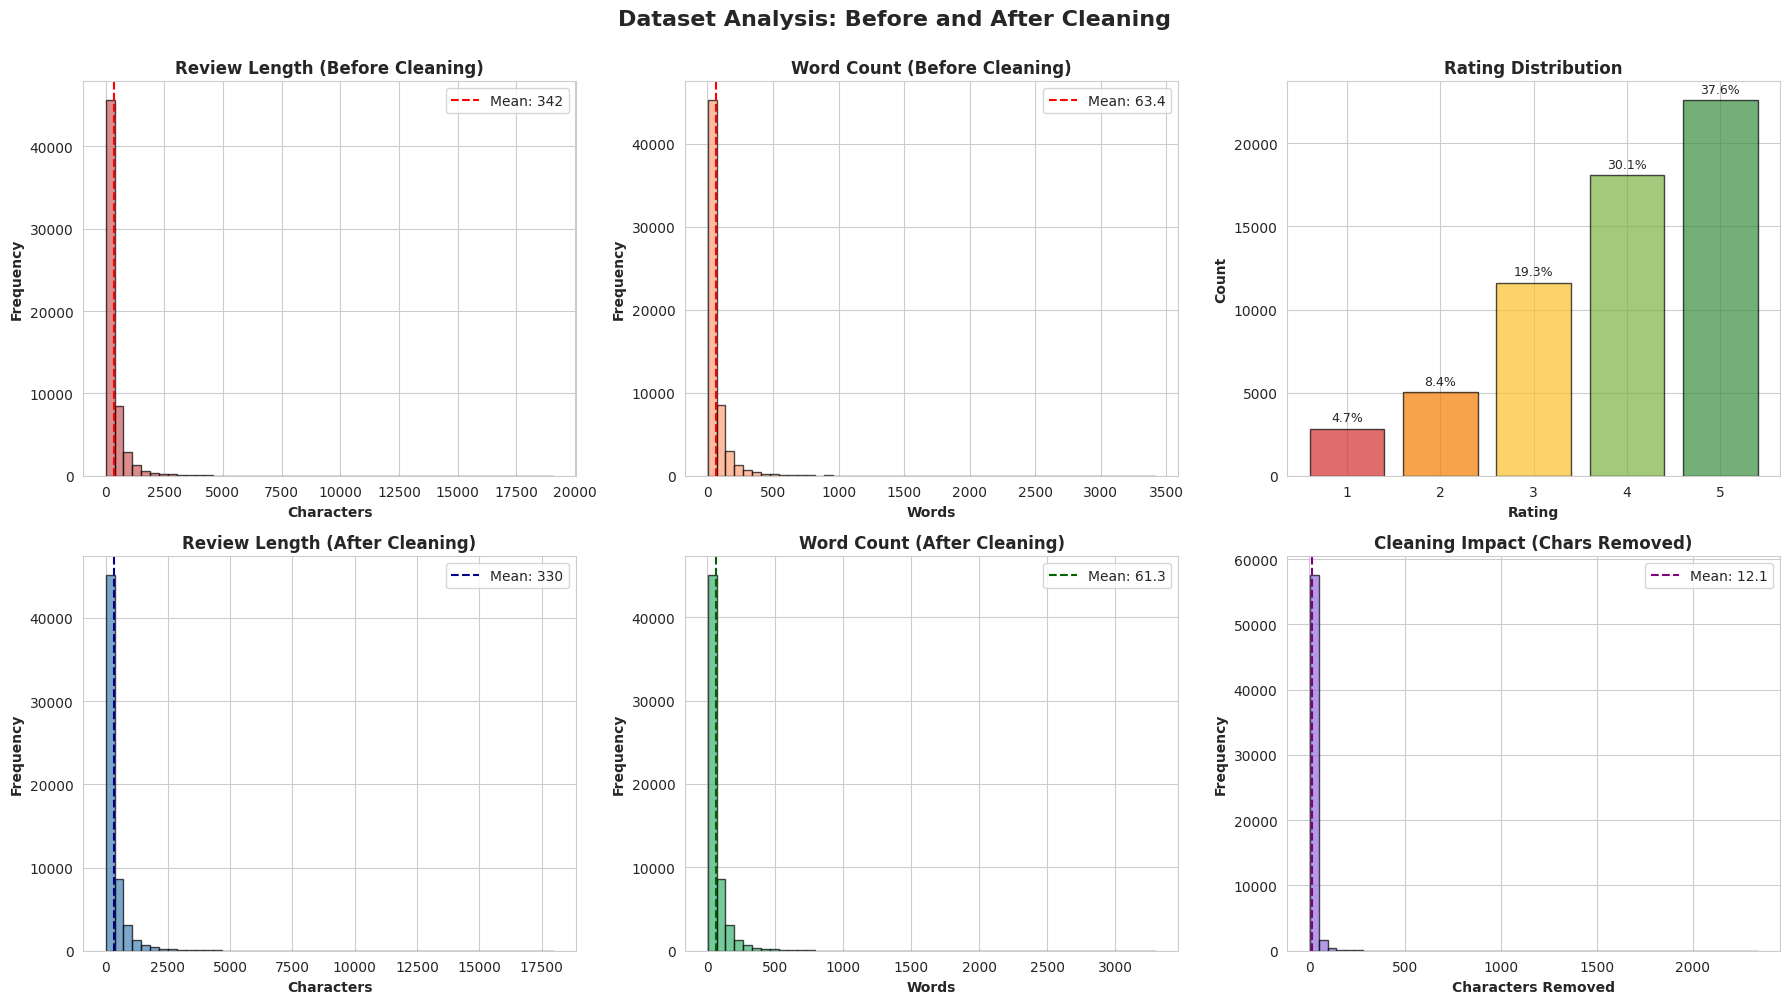


✓ Text cleaning complete!


In [ ]:
# ============================================
# CELL 2: TEXT CLEANING AND VISUALIZATION
# ============================================

print("\n" + "=" * 60)
print("TEXT CLEANING")
print("=" * 60)

# Save original for comparison (temporary variable, not saved to dataframe)
original_reviews = df['review'].copy()

def clean_arabic_text(text):
    """Clean and normalize Arabic Fusha text for AraBERT."""

    if pd.isna(text):
        return ""

    text = str(text)

    # Remove URLs, mentions, hashtags
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove tashkeel (diacritics)
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel, '', text)

    # Normalize Arabic letters
    text = re.sub('[إأآا]', 'ا', text)
    text = re.sub('ى', 'ي', text)
    text = re.sub('ؤ', 'و', text)


    # Remove tatweel (ـ)
    text = re.sub('ـ+', '', text)

    # Remove non-Arabic characters (keep numbers if you want)
    text = re.sub(r'[^\u0600-\u06FF\s]', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning - replace original review with cleaned version
print("\nApplying text cleaning...")
df['review'] = df['review'].apply(clean_arabic_text)

# Calculate metrics from variables (not saved to dataframe)
original_lengths = original_reviews.str.len()
original_word_counts = original_reviews.apply(lambda x: len(str(x).split()))

cleaned_lengths = df['review'].str.len()
cleaned_word_counts = df['review'].apply(lambda x: len(str(x).split()))

# Show examples
print("\n" + "-" * 60)
print("CLEANING EXAMPLES:")
print("-" * 60)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {original_reviews.iloc[i][:100]}...")
    print(f"Cleaned:  {df.iloc[i]['review'][:100]}...")

# Remove empty reviews
before_clean = len(df)
df = df[df['review'].str.strip() != ''].copy()
print(f"\n✓ Removed {before_clean - len(df)} empty reviews after cleaning")

# Recalculate metrics after removing empty rows
original_lengths = original_reviews.loc[df.index].str.len()
original_word_counts = original_reviews.loc[df.index].apply(lambda x: len(str(x).split()))
cleaned_lengths = df['review'].str.len()
cleaned_word_counts = df['review'].apply(lambda x: len(str(x).split()))

# Statistics
print("\n" + "-" * 60)
print("CLEANING STATISTICS:")
print("-" * 60)
print(f"Final dataset: {len(df):,} reviews")
print(f"Avg word count: {cleaned_word_counts.mean():.1f} words")
print(f"Avg character count: {cleaned_lengths.mean():.1f} chars")
print(f"Min word count: {cleaned_word_counts.min()}")
print(f"Max word count: {cleaned_word_counts.max()}")

# ============================================
# VISUALIZATIONS: BEFORE AND AFTER CLEANING
# ============================================

print("\n" + "=" * 60)
print("GENERATING VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Dataset Analysis: Before and After Cleaning',
             fontsize=16, fontweight='bold', y=1.00)

# Row 1: Before Cleaning
# Length distribution (before)
axes[0, 0].hist(original_lengths, bins=50, color='indianred',
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Characters', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Review Length (Before Cleaning)', fontweight='bold')
axes[0, 0].axvline(original_lengths.mean(), color='red', linestyle='--',
                   label=f'Mean: {original_lengths.mean():.0f}')
axes[0, 0].legend()

# Word count (before)
axes[0, 1].hist(original_word_counts, bins=50, color='lightsalmon',
                edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Words', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Word Count (Before Cleaning)', fontweight='bold')
axes[0, 1].axvline(original_word_counts.mean(), color='red', linestyle='--',
                   label=f'Mean: {original_word_counts.mean():.1f}')
axes[0, 1].legend()

# Rating distribution
rating_dist = df['rating'].value_counts().sort_index()
axes[0, 2].bar(rating_dist.index, rating_dist.values,
               color=['#d32f2f', '#f57c00', '#fbc02d', '#7cb342', '#388e3c'],
               edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Rating', fontweight='bold')
axes[0, 2].set_ylabel('Count', fontweight='bold')
axes[0, 2].set_title('Rating Distribution', fontweight='bold')
axes[0, 2].set_xticks(range(1, 6))
for rating, count in rating_dist.items():
    axes[0, 2].text(rating, count + rating_dist.max()*0.02,
                    f'{count/len(df)*100:.1f}%', ha='center', fontsize=9)

# Row 2: After Cleaning
# Length distribution (after)
axes[1, 0].hist(cleaned_lengths, bins=50, color='steelblue',
                edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Characters', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Review Length (After Cleaning)', fontweight='bold')
axes[1, 0].axvline(cleaned_lengths.mean(), color='darkblue', linestyle='--',
                   label=f'Mean: {cleaned_lengths.mean():.0f}')
axes[1, 0].legend()

# Word count (after)
axes[1, 1].hist(cleaned_word_counts, bins=50, color='mediumseagreen',
                edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Words', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Word Count (After Cleaning)', fontweight='bold')
axes[1, 1].axvline(cleaned_word_counts.mean(), color='darkgreen', linestyle='--',
                   label=f'Mean: {cleaned_word_counts.mean():.1f}')
axes[1, 1].legend()

# Comparison: Length reduction
length_diff = original_lengths - cleaned_lengths
axes[1, 2].hist(length_diff, bins=50, color='mediumpurple',
                edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Characters Removed', fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontweight='bold')
axes[1, 2].set_title('Cleaning Impact (Chars Removed)', fontweight='bold')
axes[1, 2].axvline(length_diff.mean(), color='purple', linestyle='--',
                   label=f'Mean: {length_diff.mean():.1f}')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('cleaning_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: cleaning_analysis.png")
df.to_csv("Cleaned.csv", index=False, sep='\t', encoding='utf-8')
print("✓ Saved: Cleaned.csv")
plt.show()

print("\n✓ Text cleaning complete!")

In [ ]:
# ============================================
# STEP 1: SENTIMENT BASED ON RATING
# ============================================
print("=" * 60)
print("STEP 1: SENTIMENT LABELING BASED ON RATINGS")
print("=" * 60)

df=pd.read_csv("/content/Cleaned.csv", sep="\t", header=0)

def rating_to_sentiment(rating):
    """Convert rating to sentiment: 1-2=Negative, 3=Neutral, 4-5=Positive"""
    if rating <= 2:
        return -1  # Negative
    elif rating == 3:
        return 0   # Neutral
    else:
        return 1   # Positive

# Create sentiment_note column
df['sentiment_note'] = df['rating'].apply(rating_to_sentiment)

# Statistics
print("\nSentiment Distribution (Based on Ratings):")
sentiment_counts = df['sentiment_note'].value_counts().sort_index()
for val, count in sentiment_counts.items():
    sentiment_name = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}[val]
    print(f"  {sentiment_name} ({val:2d}): {count:6,} ({count/len(df)*100:.2f}%)")

print(f"\n✓ Created column 'sentiment_note'")

# ===============================================
# STEP 2: SENTIMENT PREDICTION WITH camelbert-msa
# ===============================================
print("\n" + "=" * 60)
print("STEP 2: SENTIMENT PREDICTION WITH ARABERT")
print("=" * 60)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Load model
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-msa-sentiment"

print(f"Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"✓ Model loaded on: {device}")
print(f"Model labels: {model.config.id2label}")

def predict_sentiment(text, confidence_threshold=0.6):
    """
    Predict sentiment using AraBERT with confidence threshold.
    If confidence is low → return Neutral (0)
    """

    if pd.isna(text) or str(text).strip() == "":
        return 0  # Neutral for empty text

    try:
        inputs = tokenizer(
            str(text),
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        max_prob, predicted_class = torch.max(probs, dim=-1)
        max_prob = max_prob.item()
        predicted_class = predicted_class.item()

        # If model is not confident → Neutral
        if max_prob < confidence_threshold:
            return 0

        # Class mapping
        mapping = {
            0: 1,   # Positive
            1: -1,  # Negative
            2: 0    # Neutral
        }

        return mapping[predicted_class]

    except Exception as e:
        print(f"Error during sentiment prediction: {e}")
        return 0


# Test on first 3 reviews
print("\nTesting on 3 reviews:")
for i in range(3):
    text = df.iloc[i]['review']
    pred = predict_sentiment(text)
    print(f"\nReview {i+1}: {text[:60]}...")
    print(f"  Rating: {df.iloc[i]['rating']} → sentiment_note: {df.iloc[i]['sentiment_note']}")
    print(f"  AraBERT prediction: {pred}")

# Predict for all reviews
print(f"\n\nProcessing {len(df):,} reviews...")
arabert_predictions = []

for review in tqdm(df['review'], desc="AraBERT predictions"):
    pred = predict_sentiment(review)
    arabert_predictions.append(pred)

df['sentiment_arabert'] = arabert_predictions

print("\n✓ Created column 'sentiment_arabert'")

# Statistics
print("\nSentiment Distribution (AraBERT):")
arabert_counts = df['sentiment_arabert'].value_counts().sort_index()
for val, count in arabert_counts.items():
    sentiment_name = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}[val]
    print(f"  {sentiment_name} ({val:2d}): {count:6,} ({count/len(df)*100:.2f}%)")

STEP 1: SENTIMENT LABELING BASED ON RATINGS

Sentiment Distribution (Based on Ratings):
  Negative (-1):  7,851 (13.05%)
  Neutral ( 0): 11,614 (19.31%)
  Positive ( 1): 40,684 (67.64%)

✓ Created column 'sentiment_note'

STEP 2: SENTIMENT PREDICTION WITH ARABERT
Loading model: CAMeL-Lab/bert-base-arabic-camelbert-msa-sentiment


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

✓ Model loaded on: cuda
Model labels: {0: 'positive', 1: 'negative', 2: 'neutral'}

Testing on 3 reviews:

Review 1: مجموعة من المقالات المجمعة التي نشرت في عدة صحف ومواقع الكتا...
  Rating: 4 → sentiment_note: 1
  AraBERT prediction: 1

Review 2: بداتها البارحة وانتهيت منها صبح اليوم خمسون شخص تقلصوا خلال ...
  Rating: 5 → sentiment_note: 1
  AraBERT prediction: 0

Review 3: رواية رائعه تحكي قصة غلب المرض وضعف الحيلة رواية رائعه المتن...
  Rating: 5 → sentiment_note: 1
  AraBERT prediction: 0


Processing 60,149 reviews...


AraBERT predictions:   0%|          | 0/60149 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

AraBERT predictions: 100%|██████████| 60149/60149 [09:52<00:00, 101.50it/s]


✓ Created column 'sentiment_arabert'

Sentiment Distribution (AraBERT):
  Negative (-1): 11,859 (19.72%)
  Neutral ( 0): 16,751 (27.85%)
  Positive ( 1): 31,539 (52.43%)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# ============================================
# STEP 3: COMPARISON ANALYSIS
# ============================================
print("\n" + "=" * 60)
print("STEP 3: COMPARISON BETWEEN SENTIMENT_NOTE AND SENTIMENT_ARABERT")
print("=" * 60)

# Overall Agreement (all classes)
df['agreement'] = df['sentiment_note'] == df['sentiment_arabert']
agreement_count = df['agreement'].sum()
agreement_pct = (agreement_count / len(df)) * 100

print(f"\nOverall Agreement (All Classes): {agreement_count:,} / {len(df):,} ({agreement_pct:.2f}%)")
print(f"Disagreement: {len(df) - agreement_count:,} ({100 - agreement_pct:.2f}%)")

# Agreement EXCLUDING NEUTRAL (Negative vs Positive only)
print("\n" + "=" * 60)
print("AGREEMENT: NEGATIVE VS POSITIVE ONLY (EXCLUDING NEUTRAL)")
print("=" * 60)

# Filter out neutral from both predictions
df_no_neutral = df[
    (df['sentiment_note'] != 0) &
    (df['sentiment_arabert'] != 0)
].copy()

if len(df_no_neutral) > 0:
    agreement_no_neutral = (df_no_neutral['sentiment_note'] == df_no_neutral['sentiment_arabert']).sum()
    agreement_pct_no_neutral = (agreement_no_neutral / len(df_no_neutral)) * 100

    print(f"\nAgreement (Neg/Pos only): {agreement_no_neutral:,} / {len(df_no_neutral):,} ({agreement_pct_no_neutral:.2f}%)")
    print(f"Disagreement (Neg/Pos only): {len(df_no_neutral) - agreement_no_neutral:,} ({100 - agreement_pct_no_neutral:.2f}%)")

    # Count specific disagreements
    neg_to_pos = ((df_no_neutral['sentiment_note'] == -1) & (df_no_neutral['sentiment_arabert'] == 1)).sum()
    pos_to_neg = ((df_no_neutral['sentiment_note'] == 1) & (df_no_neutral['sentiment_arabert'] == -1)).sum()

    print(f"\nDisagreement breakdown:")
    print(f"  Negative (note) → Positive (model): {neg_to_pos:,}")
    print(f"  Positive (note) → Negative (model): {pos_to_neg:,}")
    print(f"  Total polarity flips: {neg_to_pos + pos_to_neg:,}")

# Agreement by class (including neutral for reference)
print("\n" + "-" * 60)
print("Agreement by Sentiment Class:")
print("-" * 60)
for val in [-1, 0, 1]:
    sentiment_name = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}[val]
    subset = df[df['sentiment_note'] == val]
    if len(subset) > 0:
        agree = (subset['sentiment_note'] == subset['sentiment_arabert']).sum()
        print(f"  {sentiment_name:8s}: {agree:6,} / {len(subset):6,} ({agree/len(subset)*100:.2f}%)")

# Confusion Matrix (Negative vs Positive only)
print("\n" + "-" * 60)
print("CONFUSION MATRIX (NEGATIVE VS POSITIVE ONLY)")
print("-" * 60)

if len(df_no_neutral) > 0:
    cm_no_neutral = confusion_matrix(
        df_no_neutral['sentiment_note'],
        df_no_neutral['sentiment_arabert'],
        labels=[-1, 1]
    )

    cm_df_no_neutral = pd.DataFrame(
        cm_no_neutral,
        index=['Negative', 'Positive'],
        columns=['Negative', 'Positive']
    )
    print("\n(Rows = sentiment_note, Columns = sentiment_arabert)")
    print(cm_df_no_neutral)

    # Percentage matrix
    cm_pct = cm_no_neutral.astype('float') / cm_no_neutral.sum(axis=1)[:, np.newaxis] * 100
    cm_pct_df = pd.DataFrame(
        cm_pct,
        index=['Negative', 'Positive'],
        columns=['Negative', 'Positive']
    )
    print("\nPercentages:")
    print(cm_pct_df.round(2))

# Full Confusion Matrix (all classes for reference)
print("\n" + "-" * 60)
print("CONFUSION MATRIX (ALL CLASSES)")
print("-" * 60)

cm = confusion_matrix(df['sentiment_note'], df['sentiment_arabert'],
                      labels=[-1, 0, 1])

cm_df = pd.DataFrame(cm,
                     index=['Neg (-1)', 'Neu (0)', 'Pos (1)'],
                     columns=['Neg (-1)', 'Neu (0)', 'Pos (1)'])
print("\n(Rows = sentiment_note, Columns = sentiment_arabert)")
print(cm_df)

# Classification Report (Negative vs Positive only)
print("\n" + "-" * 60)
print("CLASSIFICATION REPORT (NEGATIVE VS POSITIVE ONLY)")
print("-" * 60)

if len(df_no_neutral) > 0:
    print(classification_report(
        df_no_neutral['sentiment_note'],
        df_no_neutral['sentiment_arabert'],
        labels=[-1, 1],
        target_names=['Negative', 'Positive']
    ))

# Disagreement Examples (Negative ↔ Positive flips only)
print("\n" + "-" * 60)
print("EXAMPLES OF POLARITY FLIPS (NEGATIVE ↔ POSITIVE)")
print("-" * 60)

polarity_flips = df[
    ((df['sentiment_note'] == -1) & (df['sentiment_arabert'] == 1)) |
    ((df['sentiment_note'] == 1) & (df['sentiment_arabert'] == -1))
]

for idx, row in polarity_flips.head(10).iterrows():
    print(f"\nRating: {row['rating']} | sentiment_note: {row['sentiment_note']} | "
          f"sentiment_arabert: {row['sentiment_arabert']}")
    print(f"Review: {row['review'][:80]}...")


STEP 3: COMPARISON BETWEEN SENTIMENT_NOTE AND SENTIMENT_ARABERT

Overall Agreement (All Classes): 33,375 / 60,149 (55.49%)
Disagreement: 26,774 (44.51%)

AGREEMENT: NEGATIVE VS POSITIVE ONLY (EXCLUDING NEUTRAL)

Agreement (Neg/Pos only): 29,163 / 35,996 (81.02%)
Disagreement (Neg/Pos only): 6,833 (18.98%)

Disagreement breakdown:
  Negative (note) → Positive (model): 1,428
  Positive (note) → Negative (model): 5,405
  Total polarity flips: 6,833

------------------------------------------------------------
Agreement by Sentiment Class:
------------------------------------------------------------
  Negative:  3,927 /  7,851 (50.02%)
  Neutral :  4,212 / 11,614 (36.27%)
  Positive: 25,236 / 40,684 (62.03%)

------------------------------------------------------------
CONFUSION MATRIX (NEGATIVE VS POSITIVE ONLY)
------------------------------------------------------------

(Rows = sentiment_note, Columns = sentiment_arabert)
          Negative  Positive
Negative      3927      1428
Posit

STEP 0: DATASET INITIAL
   rating  review_id  user_id  book_id  \
0       4   94005367  2254194  6774781   
1       5  298282600  7588505  3127736   
2       5  192015457  4004303  3294671   
3       4  269310640  6682101  3165719   
4       4  439641220  9809816  3438000   

                                              review  review_length  \
0  مجموعة من المقالات المجمعة التي نشرت في عدة صح...            103   
1  بداتها البارحة وانتهيت منها صبح اليوم خمسون شخ...            247   
2  رواية رائعه تحكي قصة غلب المرض وضعف الحيلة روا...            217   
3  يجب قراءة حكومة الظل قبل عودة الغائب لكي تصل ف...             62   
4  من اكتر الروايات الكئيبة اللي ممكن تقراها في ح...            112   

   sentiment_note  sentiment_arabert  agreement  
0               1                  1       True  
1               1                  0      False  
2               1                  0      False  
3               1                  0      False  
4               1                  1       Tru

/tmp/ipython-input-2945694867.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([


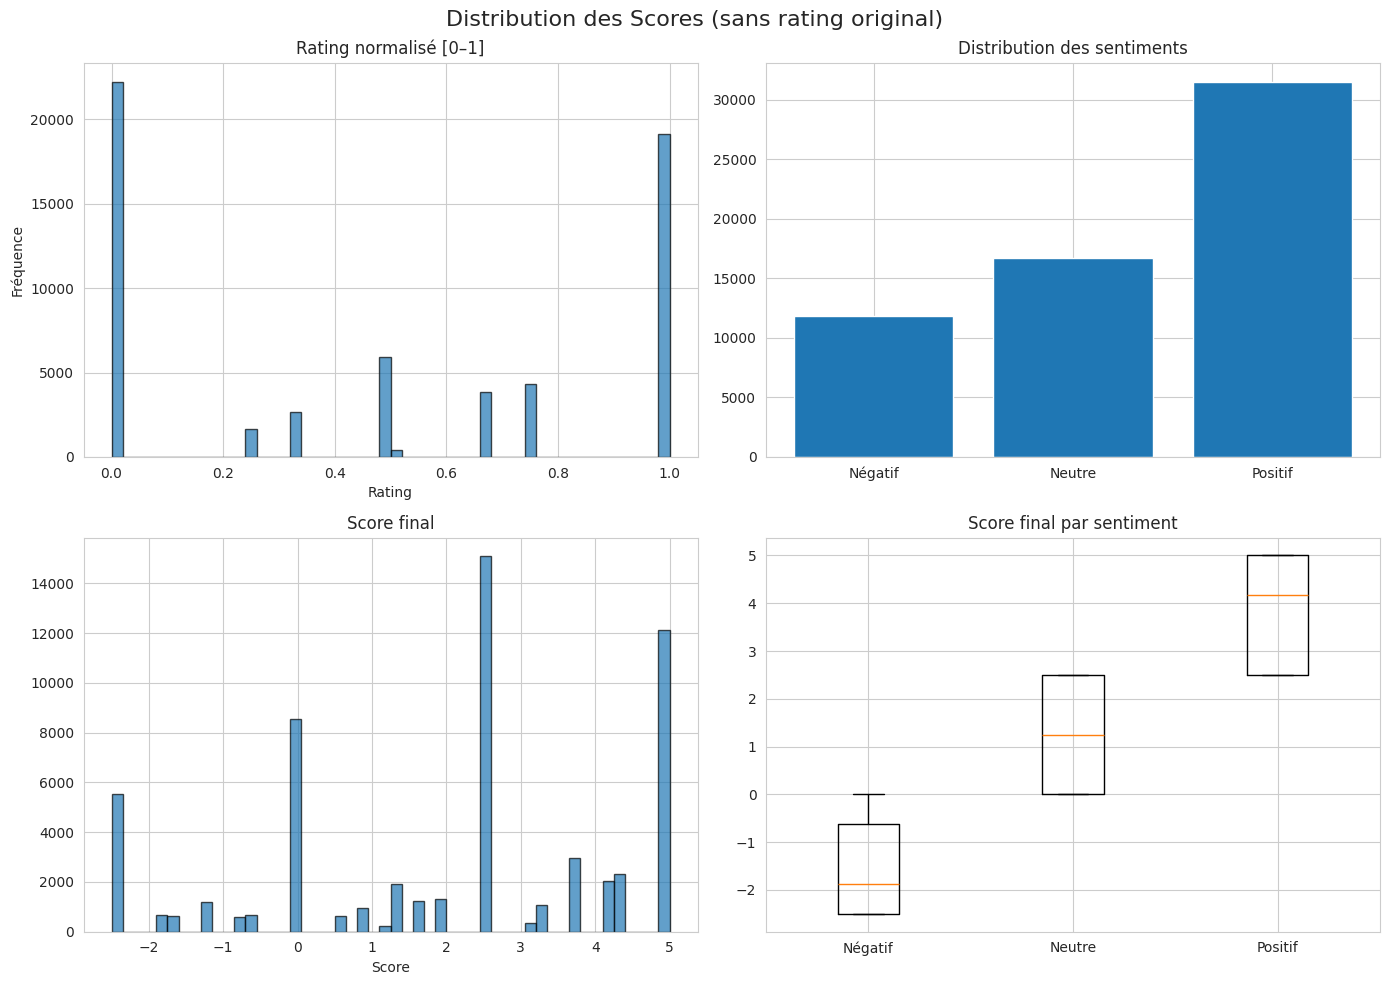

✓ score_distribution.png sauvegardé

STEP 4: TRAIN / TEST SPLIT
Train: 48,119 lignes
Test : 12,030 lignes

STEP 5: K-FOLD
fold
1    9624
2    9624
3    9624
4    9624
5    9623
Name: count, dtype: int64

STEP 6: SAUVEGARDE
✓ sentiment_analysis_final.csv
✓ train_set.csv
✓ test_set.csv

RÉSUMÉ FINAL

✓ Rating original supprimé définitivement
✓ Rating normalisé [0–1] utilisé
✓ Score final = rating normalisé + sentiment
✓ Split train/test propre
✓ K-Fold prêt
✓ Données prêtes pour GNN



In [ ]:
# ============================================================
# Normalizer les ratings et calculer les Score finaux
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

# ============================================================
# STEP 0: PRÉREQUIS
# ============================================================


print("=" * 60)
print("STEP 0: DATASET INITIAL")
print("=" * 60)
print(df.head())
print(df.columns)

# ============================================================
# STEP 1: NORMALISATION DU RATING PAR UTILISATEUR
# ============================================================

print("\n" + "=" * 60)
print("STEP 1: NORMALISATION DU RATING")
print("=" * 60)

# Moyenne et écart-type par utilisateur
user_stats = df.groupby('user_id')['rating'].agg(['mean', 'std']).reset_index()
user_stats.columns = ['user_id', 'user_mean', 'user_std']

# Sécurité division par zéro
user_stats['user_std'] = user_stats['user_std'].fillna(1)
user_stats.loc[user_stats['user_std'] == 0, 'user_std'] = 1

# Merge
df = df.merge(user_stats, on='user_id', how='left')

# Z-score
df['rating_zscore'] = (df['rating'] - df['user_mean']) / df['user_std']

# Min-Max scaling par utilisateur
scaler = MinMaxScaler((0, 1))
df['rating'] = df.groupby('user_id')['rating_zscore'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Nettoyage
df.drop(columns=['user_mean', 'user_std', 'rating_zscore'], inplace=True)

print("✓ Rating remplacé définitivement par rating normalisé [0–1]")
print(df['rating'].describe())

# ============================================================
# STEP 2: CALCUL DU SCORE FINAL
# ============================================================

print("\n" + "=" * 60)
print("STEP 2: SCORE FINAL")
print("=" * 60)

alpha = 0.5      # poids rating
Max_rating = 5        # échelle finale

df['final_score'] = (
    alpha * df['rating'] +
    (1 - alpha) * df['sentiment_arabert']
) * Max_rating

print("✓ Score final calculé")
print(df['final_score'].describe())

# ============================================================
# STEP 3: VISUALISATIONS
# ============================================================

print("\n" + "=" * 60)
print("STEP 3: VISUALISATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Distribution des Scores (sans rating original)", fontsize=16)

# Rating normalisé
axes[0, 0].hist(df['rating'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title("Rating normalisé [0–1]")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Fréquence")

# Sentiment
sentiment_counts = df['sentiment_arabert'].value_counts().sort_index()
axes[0, 1].bar(sentiment_counts.index, sentiment_counts.values)
axes[0, 1].set_title("Distribution des sentiments")
axes[0, 1].set_xticks([-1, 0, 1])
axes[0, 1].set_xticklabels(['Négatif', 'Neutre', 'Positif'])

# Score final
axes[1, 0].hist(df['final_score'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title("Score final")
axes[1, 0].set_xlabel("Score")

# Score final par sentiment
axes[1, 1].boxplot([
    df[df['sentiment_arabert'] == -1]['final_score'],
    df[df['sentiment_arabert'] == 0]['final_score'],
    df[df['sentiment_arabert'] == 1]['final_score']
], labels=['Négatif', 'Neutre', 'Positif'])
axes[1, 1].set_title("Score final par sentiment")

plt.tight_layout()
plt.savefig("score_distribution.png", dpi=300)
plt.show()

print("✓ score_distribution.png sauvegardé")

# ============================================================
# STEP 4: SPLIT TRAIN / TEST (80 / 20)
# ============================================================

print("\n" + "=" * 60)
print("STEP 4: TRAIN / TEST SPLIT")
print("=" * 60)

columns_to_keep = [
    'review_id',
    'user_id',
    'book_id',
    'rating',
    'review',
    'sentiment_note',
    'sentiment_arabert',
    'final_score'
]

df_final = df[columns_to_keep].copy()

train_df, test_df = train_test_split(
    df_final,
    test_size=0.2,
    random_state=42
)

print(f"Train: {len(train_df):,} lignes")
print(f"Test : {len(test_df):,} lignes")

# ============================================================
# STEP 5: K-FOLD CROSS-VALIDATION
# ============================================================

print("\n" + "=" * 60)
print("STEP 5: K-FOLD")
print("=" * 60)

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

train_df_cv = train_df.copy()
train_df_cv['fold'] = -1

for fold, (_, val_idx) in enumerate(kf.split(train_df_cv), 1):
    train_df_cv.iloc[val_idx, train_df_cv.columns.get_loc('fold')] = fold

print(train_df_cv['fold'].value_counts().sort_index())

# ============================================================
# STEP 6: SAUVEGARDE DES FICHIERS
# ============================================================

print("\n" + "=" * 60)
print("STEP 6: SAUVEGARDE")
print("=" * 60)

df_final.to_csv("sentiment_analysis_final.csv", index=False, encoding="utf-8")
train_df_cv.to_csv("train_set.csv", index=False, encoding="utf-8")
test_df.to_csv("test_set.csv", index=False, encoding="utf-8")

print("✓ sentiment_analysis_final.csv")
print("✓ train_set.csv")
print("✓ test_set.csv")

# ============================================================
# RÉSUMÉ FINAL
# ============================================================

print("\n" + "=" * 60)
print("RÉSUMÉ FINAL")
print("=" * 60)

print("""
✓ Rating original supprimé définitivement
✓ Rating normalisé [0–1] utilisé
✓ Score final = rating normalisé + sentiment
✓ Split train/test propre
✓ K-Fold prêt
✓ Données prêtes pour GNN
""")



EXEMPLE 1: Nettoyage avec train/test existants
PIPELINE DE NETTOYAGE DES DONNÉES

Chargement depuis: /content/sentiment_analysis_final.csv

DONNÉES ORIGINALES
Nombre total de reviews: 60149
Nombre d'utilisateurs uniques: 16485
Nombre de livres uniques: 2130

Statistiques des reviews par utilisateur:
  Moyenne: 3.65
  Médiane: 2.00
  Min: 1
  Max: 129
  Utilisateurs avec 1 seule review: 7639
  Utilisateurs avec >100 reviews: 3

Statistiques des reviews par livre:
  Moyenne: 28.24
  Médiane: 6.00
  Min: 1
  Max: 1019

Distribution des scores:
final_score
-2.500000e+00     5547
-1.875000e+00      677
-1.666667e+00      384
-1.666667e+00      261
-1.250000e+00       83
-1.250000e+00     1054
-1.250000e+00       74
-8.333333e-01       28
-8.333333e-01      351
-8.333333e-01      190
-8.333333e-01       11
-6.250000e-01        2
-6.250000e-01       88
-6.250000e-01      525
-6.250000e-01       60
-5.551115e-16       54
-2.775558e-16      230
 0.000000e+00     8119
 5.551115e-16      148
 6.

/tmp/ipython-input-2362143437.py:144: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df.groupby('user_id', group_keys=False).apply(sample_reviews)


Reviews supprimées: 0 (0.00%)
Reviews restantes: 52510
Utilisateurs: 8846

Distribution après limitation:
  Max reviews par utilisateur: 129
  Moyenne: 5.94
  Médiane: 3.00

DONNÉES NETTOYÉES
Nombre total de reviews: 52510
Nombre d'utilisateurs uniques: 8846
Nombre de livres uniques: 2075

Statistiques des reviews par utilisateur:
  Moyenne: 5.94
  Médiane: 3.00
  Min: 2
  Max: 129
  Utilisateurs avec 1 seule review: 0
  Utilisateurs avec >100 reviews: 3

Statistiques des reviews par livre:
  Moyenne: 25.31
  Médiane: 5.00
  Min: 1
  Max: 868

Distribution des scores:
final_score
-2.500000e+00     4282
-1.875000e+00      677
-1.666667e+00      384
-1.666667e+00      261
-1.250000e+00       83
-1.250000e+00     1054
-1.250000e+00       74
-8.333333e-01       28
-8.333333e-01      351
-8.333333e-01      190
-8.333333e-01       11
-6.250000e-01        2
-6.250000e-01       88
-6.250000e-01      525
-6.250000e-01       60
-5.551115e-16       54
-2.775558e-16      230
 0.000000e+00     6291

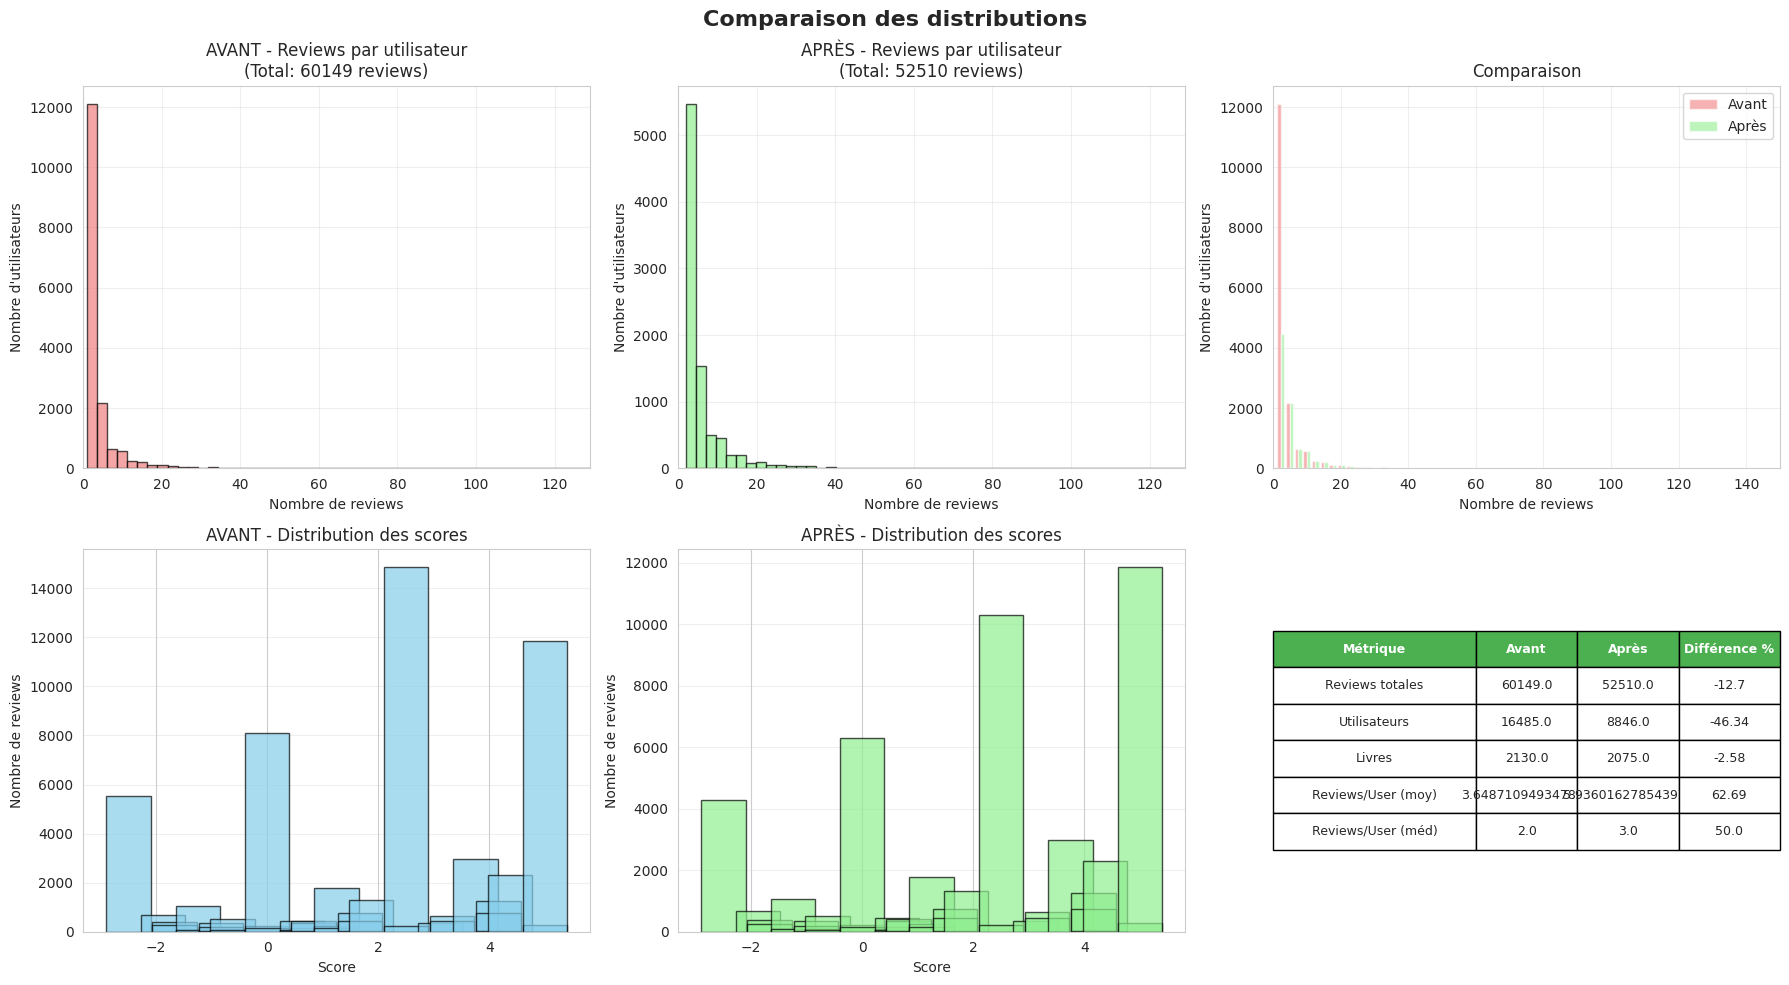


SPLIT TRAIN/TEST (80/20)
Train set: 42038 reviews, 7076 users
Test set: 10472 reviews, 1770 users

SAUVEGARDE DES FICHIERS
Train sauvegardé: train_set.csv
Test sauvegardé: test_set.csv

RÉSUMÉ FINAL
Reviews originales: 60149
Reviews nettoyées: 52510
Réduction: 12.70%

Train: 42038 reviews
Test: 10472 reviews

✓ Nettoyage terminé!
Vous pouvez maintenant utiliser 'train_set.csv' et 'test_set.csv'
avec votre code GNN existant.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# FONCTIONS DE NETTOYAGE DES DONNÉES
# =====================================================

def analyze_data_distribution(df, title="Distribution des données"):
    """Analyse la distribution des reviews par utilisateur et par livre"""

    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")

    # Statistiques globales
    print(f"Nombre total de reviews: {len(df)}")
    print(f"Nombre d'utilisateurs uniques: {df['user_id'].nunique()}")
    print(f"Nombre de livres uniques: {df['book_id'].nunique()}")

    # Distribution par utilisateur
    user_counts = df['user_id'].value_counts()
    print(f"\nStatistiques des reviews par utilisateur:")
    print(f"  Moyenne: {user_counts.mean():.2f}")
    print(f"  Médiane: {user_counts.median():.2f}")
    print(f"  Min: {user_counts.min()}")
    print(f"  Max: {user_counts.max()}")
    print(f"  Utilisateurs avec 1 seule review: {(user_counts == 1).sum()}")
    print(f"  Utilisateurs avec >100 reviews: {(user_counts > 100).sum()}")

    # Distribution par livre
    book_counts = df['book_id'].value_counts()
    print(f"\nStatistiques des reviews par livre:")
    print(f"  Moyenne: {book_counts.mean():.2f}")
    print(f"  Médiane: {book_counts.median():.2f}")
    print(f"  Min: {book_counts.min()}")
    print(f"  Max: {book_counts.max()}")

    # Distribution des scores
    print(f"\nDistribution des scores:")
    print(df['final_score'].value_counts().sort_index())

    return user_counts, book_counts


def remove_single_review_users(df):
    """Supprime les utilisateurs qui n'ont qu'une seule review"""

    print(f"\n{'='*60}")
    print("SUPPRESSION DES UTILISATEURS AVEC 1 SEULE REVIEW")
    print(f"{'='*60}")

    initial_count = len(df)
    initial_users = df['user_id'].nunique()

    # Compter les reviews par utilisateur
    user_counts = df['user_id'].value_counts()

    # Garder seulement les utilisateurs avec plus d'une review
    users_to_keep = user_counts[user_counts > 1].index
    df_filtered = df[df['user_id'].isin(users_to_keep)].copy()

    removed_reviews = initial_count - len(df_filtered)
    removed_users = initial_users - df_filtered['user_id'].nunique()

    print(f"Reviews supprimées: {removed_reviews} ({removed_reviews/initial_count*100:.2f}%)")
    print(f"Utilisateurs supprimés: {removed_users} ({removed_users/initial_users*100:.2f}%)")
    print(f"Reviews restantes: {len(df_filtered)}")
    print(f"Utilisateurs restants: {df_filtered['user_id'].nunique()}")

    return df_filtered


def limit_reviews_per_user(df, max_reviews=500, strategy='random'):
    """
    Limite le nombre de reviews par utilisateur

    Args:
        df: DataFrame avec les reviews
        max_reviews: Nombre maximum de reviews par utilisateur
        strategy: 'random', 'recent', 'highest_rated', 'lowest_rated', 'diverse'
    """

    print(f"\n{'='*60}")
    print(f"LIMITATION À {max_reviews} REVIEWS PAR UTILISATEUR")
    print(f"Stratégie: {strategy}")
    print(f"{'='*60}")

    initial_count = len(df)

    def sample_reviews(group):
        if len(group) <= max_reviews:
            return group

        if strategy == 'random':
            # Échantillonnage aléatoire
            return group.sample(n=max_reviews, random_state=42)

        elif strategy == 'recent':
            # Garder les plus récentes (si vous avez une colonne date)
            # Sinon, on prend les dernières lignes
            return group.tail(max_reviews)

        elif strategy == 'highest_rated':
            # Garder les mieux notées
            return group.nlargest(max_reviews, 'final_score')

        elif strategy == 'lowest_rated':
            # Garder les moins bien notées
            return group.nsmallest(max_reviews, 'final_score')

        elif strategy == 'diverse':
            # Stratégie diversifiée : échantillonner uniformément par score
            # Calculer combien prendre de chaque score
            score_counts = group['final_score'].value_counts()
            samples_per_score = max(1, max_reviews // len(score_counts))

            sampled = []
            for score in score_counts.index:
                score_group = group[group['final_score'] == score]
                n_sample = min(len(score_group), samples_per_score)
                sampled.append(score_group.sample(n=n_sample, random_state=42))

            result = pd.concat(sampled)

            # Si on n'a pas assez, compléter aléatoirement
            if len(result) < max_reviews:
                remaining = group[~group.index.isin(result.index)]
                additional = remaining.sample(n=min(max_reviews - len(result), len(remaining)),
                                             random_state=42)
                result = pd.concat([result, additional])

            # Si on en a trop, réduire aléatoirement
            if len(result) > max_reviews:
                result = result.sample(n=max_reviews, random_state=42)

            return result

        else:
            return group.sample(n=max_reviews, random_state=42)

    # Appliquer la limitation
    df_limited = df.groupby('user_id', group_keys=False).apply(sample_reviews)
    df_limited = df_limited.reset_index(drop=True)

    removed_reviews = initial_count - len(df_limited)

    print(f"Reviews supprimées: {removed_reviews} ({removed_reviews/initial_count*100:.2f}%)")
    print(f"Reviews restantes: {len(df_limited)}")
    print(f"Utilisateurs: {df_limited['user_id'].nunique()}")

    # Vérifier la distribution après limitation
    user_counts_after = df_limited['user_id'].value_counts()
    print(f"\nDistribution après limitation:")
    print(f"  Max reviews par utilisateur: {user_counts_after.max()}")
    print(f"  Moyenne: {user_counts_after.mean():.2f}")
    print(f"  Médiane: {user_counts_after.median():.2f}")

    return df_limited


def visualize_distributions(df_original, df_cleaned, title="Comparaison des distributions"):
    """Visualise les distributions avant/après nettoyage"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # 1. Distribution des reviews par utilisateur (AVANT)
    user_counts_original = df_original['user_id'].value_counts()
    axes[0, 0].hist(user_counts_original, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Nombre de reviews')
    axes[0, 0].set_ylabel('Nombre d\'utilisateurs')
    axes[0, 0].set_title(f'AVANT - Reviews par utilisateur\n(Total: {len(df_original)} reviews)')
    axes[0, 0].set_xlim(0, min(200, user_counts_original.max()))
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Distribution des reviews par utilisateur (APRÈS)
    user_counts_cleaned = df_cleaned['user_id'].value_counts()
    axes[0, 1].hist(user_counts_cleaned, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Nombre de reviews')
    axes[0, 1].set_ylabel('Nombre d\'utilisateurs')
    axes[0, 1].set_title(f'APRÈS - Reviews par utilisateur\n(Total: {len(df_cleaned)} reviews)')
    axes[0, 1].set_xlim(0, min(200, user_counts_cleaned.max()))
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Comparaison directe
    axes[0, 2].hist([user_counts_original, user_counts_cleaned],
                    bins=50, label=['Avant', 'Après'],
                    color=['lightcoral', 'lightgreen'], alpha=0.6)
    axes[0, 2].set_xlabel('Nombre de reviews')
    axes[0, 2].set_ylabel('Nombre d\'utilisateurs')
    axes[0, 2].set_title('Comparaison')
    axes[0, 2].set_xlim(0, 150)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Distribution des scores (AVANT)
    score_dist_original = df_original['final_score'].value_counts().sort_index()
    axes[1, 0].bar(score_dist_original.index, score_dist_original.values,
                   color='skyblue', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].set_ylabel('Nombre de reviews')
    axes[1, 0].set_title('AVANT - Distribution des scores')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 5. Distribution des scores (APRÈS)
    score_dist_cleaned = df_cleaned['final_score'].value_counts().sort_index()
    axes[1, 1].bar(score_dist_cleaned.index, score_dist_cleaned.values,
                   color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Score')
    axes[1, 1].set_ylabel('Nombre de reviews')
    axes[1, 1].set_title('APRÈS - Distribution des scores')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # 6. Statistiques comparatives
    stats_data = {
        'Métrique': ['Reviews totales', 'Utilisateurs', 'Livres',
                     'Reviews/User (moy)', 'Reviews/User (méd)'],
        'Avant': [
            len(df_original),
            df_original['user_id'].nunique(),
            df_original['book_id'].nunique(),
            user_counts_original.mean(),
            user_counts_original.median()
        ],
        'Après': [
            len(df_cleaned),
            df_cleaned['user_id'].nunique(),
            df_cleaned['book_id'].nunique(),
            user_counts_cleaned.mean(),
            user_counts_cleaned.median()
        ]
    }

    stats_df = pd.DataFrame(stats_data)
    stats_df['Différence %'] = ((stats_df['Après'] - stats_df['Avant']) / stats_df['Avant'] * 100).round(2)

    axes[1, 2].axis('off')
    table = axes[1, 2].table(cellText=stats_df.values, colLabels=stats_df.columns,
                             cellLoc='center', loc='center',
                             colWidths=[0.4, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style du tableau
    for i in range(len(stats_df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.show()


def clean_and_split_data(input_path, output_train_path, output_test_path,
                         remove_single_reviews=True,
                         max_reviews_per_user=100,
                         sampling_strategy='random',
                         test_size=0.2,
                         visualize=True):
    """
    Pipeline complet de nettoyage et de split des données

    Args:
        input_path: Chemin vers le fichier d'entrée (ou tuple de (train, test))
        output_train_path: Chemin de sortie pour le train set
        output_test_path: Chemin de sortie pour le test set
        remove_single_reviews: Supprimer les utilisateurs avec 1 review
        max_reviews_per_user: Nombre max de reviews par utilisateur (None = pas de limite)
        sampling_strategy: 'random', 'recent', 'highest_rated', 'lowest_rated', 'diverse'
        test_size: Proportion du test set (0.2 = 20%)
        visualize: Afficher les visualisations
    """

    print("="*60)
    print("PIPELINE DE NETTOYAGE DES DONNÉES")
    print("="*60)

    # Charger les données
    if isinstance(input_path, tuple):
        print(f"\nChargement depuis train/test existants...")
        train_df = pd.read_csv(input_path[0])
        test_df = pd.read_csv(input_path[1])
        df = pd.concat([train_df, test_df], ignore_index=True)
    else:
        print(f"\nChargement depuis: {input_path}")
        df = pd.read_csv(input_path)

    df_original = df.copy()

    # Analyse initiale
    analyze_data_distribution(df, "DONNÉES ORIGINALES")

    # Étape 1: Supprimer les utilisateurs avec une seule review
    if remove_single_reviews:
        df = remove_single_review_users(df)

    # Étape 2: Limiter les reviews par utilisateur
    if max_reviews_per_user is not None:
        df = limit_reviews_per_user(df, max_reviews_per_user, sampling_strategy)

    # Analyse après nettoyage
    analyze_data_distribution(df, "DONNÉES NETTOYÉES")

    # Visualisation
    if visualize:
        visualize_distributions(df_original, df)

    # Split train/test
    print(f"\n{'='*60}")
    print(f"SPLIT TRAIN/TEST ({int((1-test_size)*100)}/{int(test_size*100)})")
    print(f"{'='*60}")

    # Stratégie: split par utilisateur pour éviter le data leakage
    unique_users = df['user_id'].unique()
    np.random.seed(42)
    np.random.shuffle(unique_users)

    split_idx = int(len(unique_users) * (1 - test_size))
    train_users = unique_users[:split_idx]
    test_users = unique_users[split_idx:]

    train_df_clean = df[df['user_id'].isin(train_users)].reset_index(drop=True)
    test_df_clean = df[df['user_id'].isin(test_users)].reset_index(drop=True)

    print(f"Train set: {len(train_df_clean)} reviews, {train_df_clean['user_id'].nunique()} users")
    print(f"Test set: {len(test_df_clean)} reviews, {test_df_clean['user_id'].nunique()} users")

    # Sauvegarder
    print(f"\n{'='*60}")
    print("SAUVEGARDE DES FICHIERS")
    print(f"{'='*60}")

    train_df_clean.to_csv(output_train_path, index=False)
    test_df_clean.to_csv(output_test_path, index=False)

    print(f"Train sauvegardé: {output_train_path}")
    print(f"Test sauvegardé: {output_test_path}")

    # Résumé final
    print(f"\n{'='*60}")
    print("RÉSUMÉ FINAL")
    print(f"{'='*60}")
    print(f"Reviews originales: {len(df_original)}")
    print(f"Reviews nettoyées: {len(df)}")
    print(f"Réduction: {(1 - len(df)/len(df_original))*100:.2f}%")
    print(f"\nTrain: {len(train_df_clean)} reviews")
    print(f"Test: {len(test_df_clean)} reviews")

    return train_df_clean, test_df_clean


# =====================================================
# EXEMPLES D'UTILISATION
# =====================================================

def example_usage():
    """Exemples d'utilisation du pipeline de nettoyage"""

    # EXEMPLE 1: Pipeline complet avec train/test existants
    print("\n" + "="*60)
    print("EXEMPLE 1: Nettoyage avec train/test existants")
    print("="*60)



    # EXEMPLE 2: Avec un seul fichier source
    train_clean, test_clean = clean_and_split_data(
         input_path='/content/sentiment_analysis_final.csv',
         output_train_path='train_set.csv',
         output_test_path='test_set.csv',
         remove_single_reviews=True,
         max_reviews_per_user=500,
         sampling_strategy='diverse',
         test_size=0.2,
         visualize=True
     )


    return train_clean, test_clean


# =====================================================
# EXÉCUTION
# =====================================================

if __name__ == "__main__":
    # Lancer le pipeline de nettoyage
    train_cleaned, test_cleaned = example_usage()

    print("\n✓ Nettoyage terminé!")
    print("Vous pouvez maintenant utiliser 'train_set.csv' et 'test_set.csv'")
    print("avec votre code GNN existant.")

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.8 MB/s eta 0:00:00


CHARGEMENT DES DONNÉES
Train shape: (42038, 8)
Test shape: (10472, 8)

CONSTRUCTION DU GRAPHE
Nombre d'utilisateurs: 8846
Nombre de livres: 2075
Nombre d'interactions: 52510
Edge weights - min: 0.0000, max: 1.0000, mean: 0.6238
Edge index shape: torch.Size([2, 105020])
Nombre total d'arêtes: 105020

Création des DataLoaders...
Utilisation de: cuda

ENTRAÎNEMENT: GCN
Starting training with lr=0.0005, weight_decay=1e-05
Model parameters: 757,761
Epoch 5/70:
  Train Loss: 4.1199
  Val Loss: 4.5474, RMSE: 2.1350, MAE: 1.7698
Epoch 10/70:
  Train Loss: 3.2928
  Val Loss: 4.5197, RMSE: 2.1255, MAE: 1.7074
Epoch 15/70:
  Train Loss: 2.8811
  Val Loss: 4.4257, RMSE: 2.1040, MAE: 1.6951
Epoch 20/70:
  Train Loss: 2.5792
  Val Loss: 4.4072, RMSE: 2.1003, MAE: 1.6777
Epoch 25/70:
  Train Loss: 2.3264
  Val Loss: 4.4838, RMSE: 2.1183, MAE: 1.6861
Early stopping à l'epoch 29

Temps d'entraînement total: 66.54 secondes
Meilleurs résultats - RMSE: 2.0987, Val Loss: 4.3973


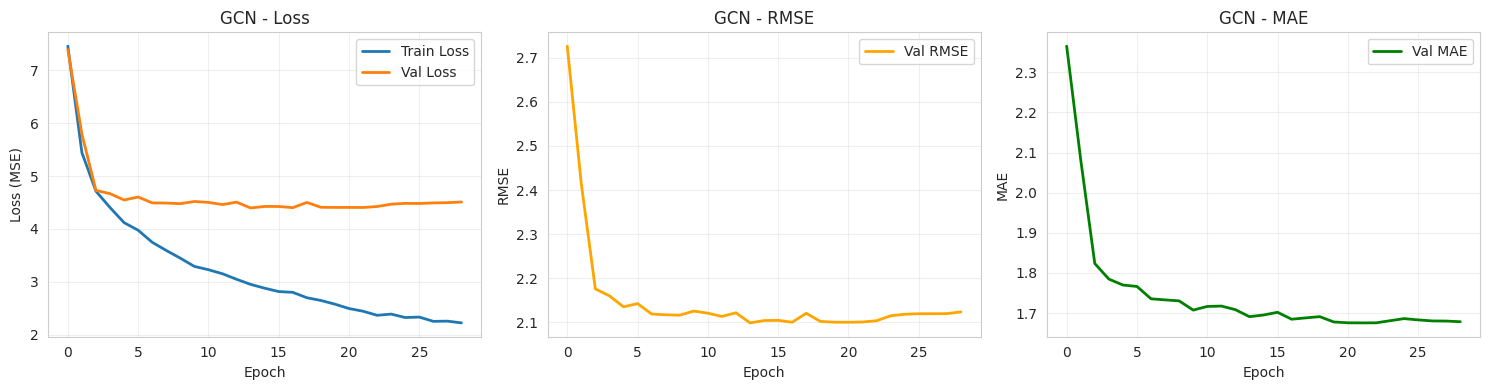

ENTRAÎNEMENT: GraphSAGE
Starting training with lr=0.0005, weight_decay=1e-05
Model parameters: 790,401
Epoch 5/70:
  Train Loss: 4.5910
  Val Loss: 5.2757, RMSE: 2.3019, MAE: 1.9154
Epoch 10/70:
  Train Loss: 4.1522
  Val Loss: 5.3785, RMSE: 2.3247, MAE: 1.9435
Epoch 15/70:
  Train Loss: 3.9193
  Val Loss: 5.4090, RMSE: 2.3304, MAE: 1.9240
Early stopping à l'epoch 17

Temps d'entraînement total: 17.93 secondes
Meilleurs résultats - RMSE: 2.2834, Val Loss: 5.1947


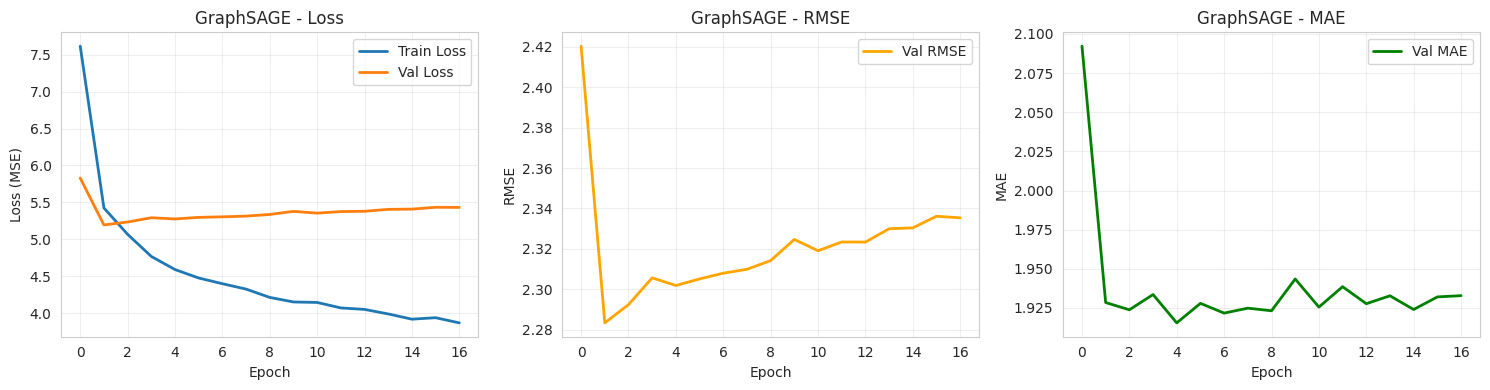

ENTRAÎNEMENT: GAT
Starting training with lr=0.0005, weight_decay=1e-05
Model parameters: 758,273
Epoch 5/70:
  Train Loss: 5.1490
  Val Loss: 5.1731, RMSE: 2.2772, MAE: 1.8972
Epoch 10/70:
  Train Loss: 4.8906
  Val Loss: 5.2535, RMSE: 2.2936, MAE: 1.8980
Epoch 15/70:
  Train Loss: 4.6220
  Val Loss: 5.3568, RMSE: 2.3164, MAE: 1.9097
Epoch 20/70:
  Train Loss: 4.4991
  Val Loss: 5.4955, RMSE: 2.3465, MAE: 1.9260
Early stopping à l'epoch 21

Temps d'entraînement total: 33.79 secondes
Meilleurs résultats - RMSE: 2.2751, Val Loss: 5.1686


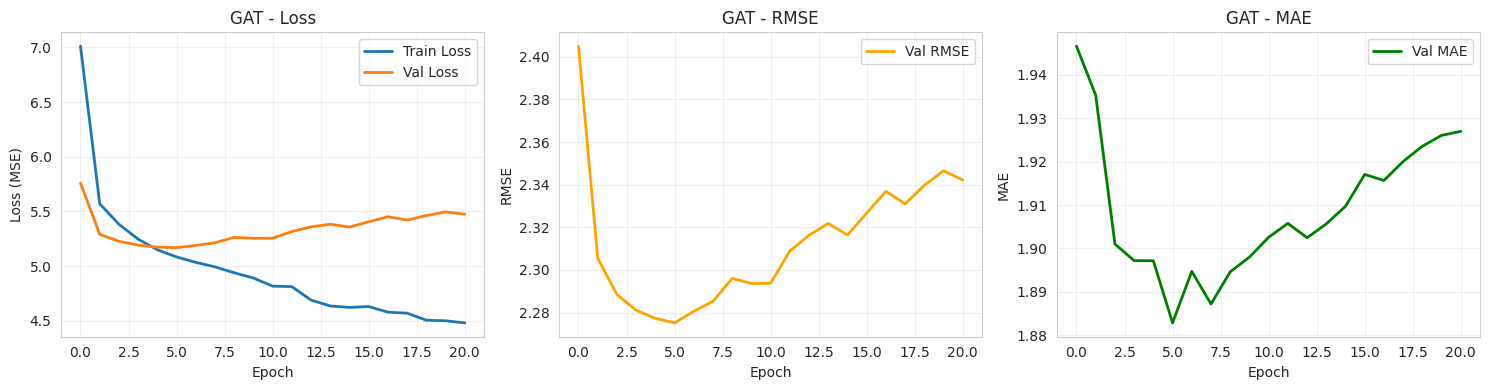


TABLEAU COMPARATIF DES MODÈLES
           val_loss      rmse       mae  training_time
GCN        4.397302  2.098713  1.678334      66.541846
GraphSAGE  5.194695  2.283430  1.932844      17.931281
GAT        5.168552  2.275127  1.926981      33.788271


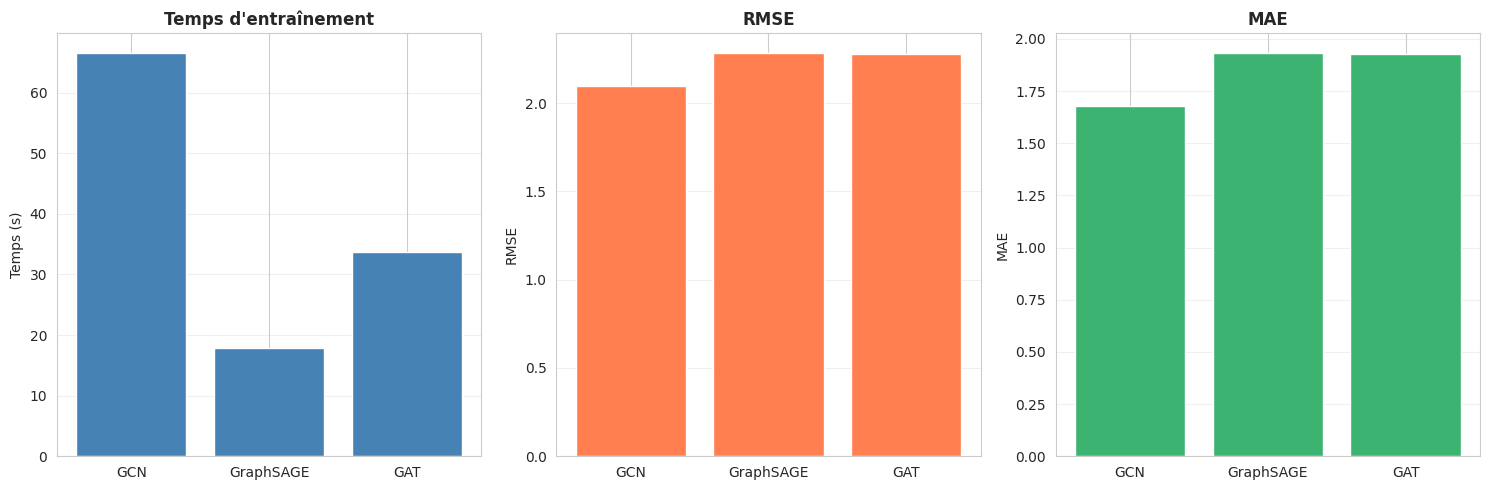

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader

# =====================================================
# 1. CONSTRUCTION DU GRAPHE (AMÉLIORÉ)
# =====================================================

class GraphBuilder:
    """Construit un graphe biparti utilisateur-livre optimisé"""

    def __init__(self, df):
        self.df = df

        # Créer des mappings pour les IDs
        self.user_mapping = {user: idx for idx, user in enumerate(df['user_id'].unique())}
        self.book_mapping = {book: idx for idx, book in enumerate(df['book_id'].unique())}

        self.n_users = len(self.user_mapping)
        self.n_books = len(self.book_mapping)

        print(f"Nombre d'utilisateurs: {self.n_users}")
        print(f"Nombre de livres: {self.n_books}")
        print(f"Nombre d'interactions: {len(df)}")

    def build_edge_index_and_weights(self):
        """Construit l'edge_index et les poids pour un graphe biparti"""

        # Mapper les IDs
        users = torch.tensor([self.user_mapping[u] for u in self.df['user_id']], dtype=torch.long)
        books = torch.tensor([self.book_mapping[b] for b in self.df['book_id']], dtype=torch.long)

        # Les livres commencent après tous les utilisateurs
        books_offset = books + self.n_users

        # Créer les arêtes bidirectionnelles
        edge_index_forward = torch.stack([users, books_offset], dim=0)
        edge_index_backward = torch.stack([books_offset, users], dim=0)
        edge_index = torch.cat([edge_index_forward, edge_index_backward], dim=1)

        # Poids des arêtes (scores normalisés entre 0 et 1)
        edge_weights = torch.tensor(self.df['final_score'].values, dtype=torch.float)

        # Normalize to [0, 1] range instead of z-score to avoid negative weights
        min_score = edge_weights.min()
        max_score = edge_weights.max()
        if max_score > min_score:
            edge_weights = (edge_weights - min_score) / (max_score - min_score)
        else:
            edge_weights = torch.ones_like(edge_weights)

        # Add small epsilon to avoid zero weights
        edge_weights = edge_weights + 1e-6

        # Dupliquer pour les deux directions
        edge_weights = torch.cat([edge_weights, edge_weights], dim=0)

        print(f"Edge weights - min: {edge_weights.min():.4f}, max: {edge_weights.max():.4f}, mean: {edge_weights.mean():.4f}")

        return edge_index, edge_weights


# =====================================================
# 2. DATASET ET DATALOADER (OPTIMISÉ)
# =====================================================

class ReviewDataset(Dataset):
    """Dataset pour les avis utilisateur-livre"""

    def __init__(self, df, user_mapping, book_mapping):
        self.user_ids = torch.tensor([user_mapping[u] for u in df['user_id'].values], dtype=torch.long)
        self.book_ids = torch.tensor([book_mapping[b] for b in df['book_id'].values], dtype=torch.long)
        self.targets = torch.tensor(df['final_score'].values, dtype=torch.float)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.book_ids[idx], self.targets[idx]


def create_dataloaders(train_df, test_df, builder, batch_size=512):
    """Crée les DataLoaders pour train et test"""

    train_dataset = ReviewDataset(train_df, builder.user_mapping, builder.book_mapping)
    test_dataset = ReviewDataset(test_df, builder.user_mapping, builder.book_mapping)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader


# =====================================================
# 3. MODÈLES GNN (AMÉLIORÉS)
# =====================================================

class ImprovedGCNRecommender(nn.Module):
    """GCN amélioré avec normalisation et skip connections"""

    def __init__(self, n_users, n_books, embedding_dim=64, hidden_dim=128, num_layers=3):
        super().__init__()

        self.n_users = n_users
        self.n_books = n_books
        self.embedding_dim = embedding_dim

        # Embeddings avec initialisation Xavier et scale
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)

        # Initialize with smaller values to prevent explosion
        nn.init.xavier_uniform_(self.user_embedding.weight, gain=0.5)
        nn.init.xavier_uniform_(self.book_embedding.weight, gain=0.5)

        # Couches de convolution
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # Première couche
        self.convs.append(GCNConv(embedding_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Couches intermédiaires
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Dernière couche
        self.convs.append(GCNConv(hidden_dim, embedding_dim))

        # Prédicteur amélioré avec initialisation
        self.predictor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        # Initialize predictor
        for m in self.predictor.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, user_ids, book_ids, edge_index, edge_weight=None):
        # Créer le graphe complet
        all_users_emb = self.user_embedding.weight
        all_books_emb = self.book_embedding.weight
        x = torch.cat([all_users_emb, all_books_emb], dim=0)

        # Appliquer les convolutions avec skip connections
        x_input = x
        for i, (conv, bn) in enumerate(zip(self.convs[:-1], self.batch_norms)):
            # ✓ Pass edge_weight to GCNConv
            x = conv(x, edge_index, edge_weight=edge_weight)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.3, training=self.training)

        # Dernière couche with edge weights
        x = self.convs[-1](x, edge_index, edge_weight=edge_weight)

        # Skip connection depuis l'entrée
        x = x + x_input[:x.size(0)]

        # Extraire les embeddings du batch
        user_final = x[user_ids]
        book_final = x[book_ids + self.n_users]

        # Prédiction
        combined = torch.cat([user_final, book_final], dim=1)
        return self.predictor(combined).squeeze()


class ImprovedGraphSAGERecommender(nn.Module):
    """GraphSAGE amélioré"""

    def __init__(self, n_users, n_books, embedding_dim=64, hidden_dim=128):
        super().__init__()

        self.n_users = n_users
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.book_embedding.weight)

        self.conv1 = SAGEConv(embedding_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, embedding_dim)

        self.predictor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, user_ids, book_ids, edge_index, edge_weight=None):
        all_users_emb = self.user_embedding.weight
        all_books_emb = self.book_embedding.weight
        x = torch.cat([all_users_emb, all_books_emb], dim=0)

        x_input = x
        # ✓ SAGEConv doesn't support edge_weight parameter directly
        # It uses edge_weight implicitly if provided in edge_attr during message passing
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv3(x, edge_index)
        x = x + x_input

        user_final = x[user_ids]
        book_final = x[book_ids + self.n_users]

        combined = torch.cat([user_final, book_final], dim=1)
        return self.predictor(combined).squeeze()


class ImprovedGATRecommender(nn.Module):
    """GAT amélioré avec plus de têtes d'attention"""

    def __init__(self, n_users, n_books, embedding_dim=64, hidden_dim=128, heads=8):
        super().__init__()

        self.n_users = n_users
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.book_embedding.weight)

        # Ajuster hidden_dim pour être divisible par heads
        self.conv1 = GATConv(embedding_dim, hidden_dim // heads, heads=heads, dropout=0.2)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, dropout=0.2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GATConv(hidden_dim, embedding_dim, heads=1, concat=False)

        self.predictor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, user_ids, book_ids, edge_index, edge_weight=None):
        all_users_emb = self.user_embedding.weight
        all_books_emb = self.book_embedding.weight
        x = torch.cat([all_users_emb, all_books_emb], dim=0)

        x_input = x
        # ✓ GATConv doesn't support edge_weight in the traditional sense
        # It learns attention weights, but we can influence via edge_attr
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv3(x, edge_index)
        x = x + x_input

        user_final = x[user_ids]
        book_final = x[book_ids + self.n_users]

        combined = torch.cat([user_final, book_final], dim=1)
        return self.predictor(combined).squeeze()


# =====================================================
# 4. ENTRAÎNEMENT ET ÉVALUATION (OPTIMISÉ)
# =====================================================

class GNNTrainer:
    """Classe pour entraîner et comparer les modèles GNN"""

    def __init__(self, model, edge_index, edge_weight=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.edge_index = edge_index.to(device)
        self.edge_weight = edge_weight.to(device) if edge_weight is not None else None
        self.train_losses = []
        self.val_losses = []
        self.val_rmses = []
        self.val_maes = []
        self.training_time = 0

    def train_epoch(self, train_loader, optimizer, criterion, scheduler=None):
        self.model.train()
        total_loss = 0
        num_batches = 0

        for user_ids, book_ids, targets in train_loader:
            user_ids = user_ids.to(self.device)
            book_ids = book_ids.to(self.device)
            targets = targets.to(self.device)

            optimizer.zero_grad()
            predictions = self.model(user_ids, book_ids, self.edge_index, self.edge_weight)

            # Check for NaN in predictions during training
            if torch.isnan(predictions).any():
                print(f"WARNING: NaN in predictions during training at batch {num_batches}")
                continue  # Skip this batch

            loss = criterion(predictions, targets)

            # Check for NaN in loss
            if torch.isnan(loss):
                print(f"WARNING: NaN loss at batch {num_batches}")
                continue  # Skip this batch

            loss.backward()

            # Gradient clipping pour stabilité
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Check for NaN in gradients
            has_nan_grad = False
            for param in self.model.parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    has_nan_grad = True
                    break

            if has_nan_grad:
                print(f"WARNING: NaN in gradients at batch {num_batches}")
                optimizer.zero_grad()
                continue

            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        if scheduler is not None:
            scheduler.step()

        return total_loss / max(num_batches, 1)  # Avoid division by zero

    def evaluate(self, val_loader, criterion):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_targets = []
        num_batches = 0

        with torch.no_grad():
            for user_ids, book_ids, targets in val_loader:
                user_ids = user_ids.to(self.device)
                book_ids = book_ids.to(self.device)
                targets = targets.to(self.device)

                predictions = self.model(user_ids, book_ids, self.edge_index, self.edge_weight)

                # Check for NaN in predictions
                if torch.isnan(predictions).any():
                    print(f"WARNING: NaN detected in predictions!")
                    print(f"User IDs range: {user_ids.min()}-{user_ids.max()}")
                    print(f"Book IDs range: {book_ids.min()}-{book_ids.max()}")
                    # Replace NaN with mean target value
                    predictions = torch.nan_to_num(predictions, nan=targets.mean().item())

                loss = criterion(predictions, targets)

                total_loss += loss.item()
                all_preds.extend(predictions.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                num_batches += 1

        # Final check for NaN values
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        if np.isnan(all_preds).any():
            print(f"WARNING: {np.isnan(all_preds).sum()} NaN values in predictions, replacing with mean")
            all_preds = np.nan_to_num(all_preds, nan=np.nanmean(all_preds))

        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        mae = mean_absolute_error(all_targets, all_preds)

        return total_loss / num_batches, rmse, mae, all_preds, all_targets

    def train(self, train_loader, val_loader, epochs=90, lr=0.0005, weight_decay=1e-5):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        best_rmse = float('inf')
        patience = 15
        patience_counter = 0

        start_time = time.time()

        print(f"Starting training with lr={lr}, weight_decay={weight_decay}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader, optimizer, criterion)

            # Check if training loss is valid
            if np.isnan(train_loss) or np.isinf(train_loss):
                print(f"ERROR: Invalid train loss at epoch {epoch+1}: {train_loss}")
                print("Training stopped due to numerical instability")
                break

            val_loss, rmse, mae, _, _ = self.evaluate(val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_rmses.append(rmse)
            self.val_maes.append(mae)

            scheduler.step(val_loss)

            if (epoch + 1) % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs}:')
                print(f'  Train Loss: {train_loss:.4f}')
                print(f'  Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')
            # Early stopping basé sur RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_val_loss = val_loss
                patience_counter = 0
                # Sauvegarder le meilleur modèle
                self.best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping à l\'epoch {epoch+1}')
                    # Restaurer le meilleur modèle
                    self.model.load_state_dict(self.best_model_state)
                    break



        self.training_time = time.time() - start_time
        print(f'\nTemps d\'entraînement total: {self.training_time:.2f} secondes')
        print(f'Meilleurs résultats - RMSE: {best_rmse:.4f}, Val Loss: {best_val_loss:.4f}')

        return best_val_loss, best_rmse, mae

    def plot_learning_curves(self, model_name):
        """Affiche les courbes d'apprentissage"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Loss
        axes[0].plot(self.train_losses, label='Train Loss', linewidth=2)
        axes[0].plot(self.val_losses, label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss (MSE)')
        axes[0].set_title(f'{model_name} - Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # RMSE
        axes[1].plot(self.val_rmses, label='Val RMSE', color='orange', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('RMSE')
        axes[1].set_title(f'{model_name} - RMSE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # MAE
        axes[2].plot(self.val_maes, label='Val MAE', color='green', linewidth=2)
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MAE')
        axes[2].set_title(f'{model_name} - MAE')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# =====================================================
# 5. FONCTION PRINCIPALE DE COMPARAISON
# =====================================================

def compare_gnn_models(train_path='train_set.csv', test_path='test_set.csv'):
    """Compare les trois modèles GNN améliorés"""

    print("=" * 60)
    print("CHARGEMENT DES DONNÉES")
    print("=" * 60)

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")

    # Combiner pour créer les mappings complets
    df_combined = pd.concat([train_df, test_df], ignore_index=True)

    print("\n" + "=" * 60)
    print("CONSTRUCTION DU GRAPHE")
    print("=" * 60)

    builder = GraphBuilder(df_combined)
    edge_index, edge_weight = builder.build_edge_index_and_weights()

    print(f"Edge index shape: {edge_index.shape}")
    print(f"Nombre total d'arêtes: {edge_index.shape[1]}")

    print("\nCréation des DataLoaders...")
    train_loader, test_loader = create_dataloaders(train_df, test_df, builder, batch_size=1024)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Utilisation de: {device}\n")

    # Modèles à tester
    models = {
        'GCN': ImprovedGCNRecommender(builder.n_users, builder.n_books),
        'GraphSAGE': ImprovedGraphSAGERecommender(builder.n_users, builder.n_books),
        'GAT': ImprovedGATRecommender(builder.n_users, builder.n_books)
    }

    results = {}

    for name, model in models.items():
        print("=" * 60)
        print(f"ENTRAÎNEMENT: {name}")
        print("=" * 60)

        trainer = GNNTrainer(model, edge_index, edge_weight, device)
        val_loss, rmse, mae = trainer.train(train_loader, test_loader, epochs=70, lr=0.0005)

        trainer.plot_learning_curves(name)

        results[name] = {
            'val_loss': val_loss,
            'rmse': rmse,
            'mae': mae,
            'training_time': trainer.training_time
        }

    # Afficher le tableau comparatif
    print("\n" + "=" * 60)
    print("TABLEAU COMPARATIF DES MODÈLES")
    print("=" * 60)

    df_results = pd.DataFrame(results).T
    print(df_results.to_string())

    # Visualisation comparative
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    model_names = list(results.keys())

    axes[0].bar(model_names, [r['training_time'] for r in results.values()], color='steelblue')
    axes[0].set_title('Temps d\'entraînement', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Temps (s)')
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].bar(model_names, [r['rmse'] for r in results.values()], color='coral')
    axes[1].set_title('RMSE', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('RMSE')
    axes[1].grid(True, alpha=0.3, axis='y')

    axes[2].bar(model_names, [r['mae'] for r in results.values()], color='mediumseagreen')
    axes[2].set_title('MAE', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('MAE')
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return results, builder


# Exemple d'utilisation
if __name__ == "__main__":
    results, builder = compare_gnn_models('/content/train_set.csv', '/content/test_set.csv')

COMPARISON: LightGCN vs Standard GCN

Data: 42038 train, 10472 test
Nombre d'utilisateurs: 8846
Nombre de livres: 2075
Nombre d'interactions: 52510
Device: cuda

LightGCN with 2 layers

🚀 Training LightGCN
   Learning rate: 0.001
   Weight decay: 1e-05
   Epochs: 50
   Model parameters: 707,265
Epoch 5/50:
  Train Loss: 4.8593
  Val Loss: 5.5563, RMSE: 2.3583, MAE: 1.9653
Epoch 10/50:
  Train Loss: 4.1650
  Val Loss: 5.8663, RMSE: 2.4213, MAE: 2.0173
Epoch 15/50:
  Train Loss: 3.8989
  Val Loss: 5.8671, RMSE: 2.4240, MAE: 2.0200
Early stopping at epoch 18

✓ Training completed in 29.50s
  Best RMSE: 2.3280


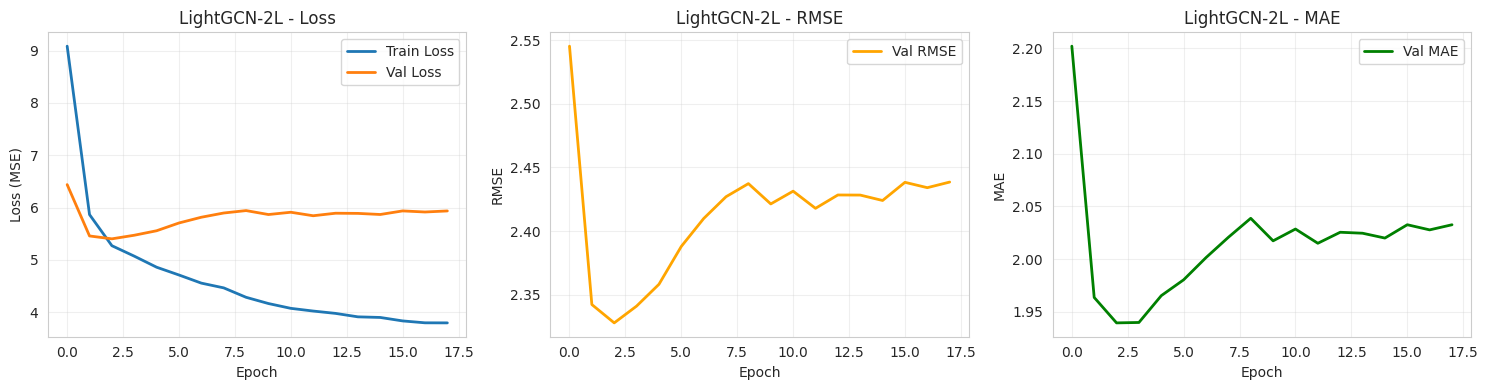

LightGCN with 3 layers

🚀 Training LightGCN
   Learning rate: 0.001
   Weight decay: 1e-05
   Epochs: 50
   Model parameters: 707,265
Epoch 5/50:
  Train Loss: 4.9451
  Val Loss: 5.5269, RMSE: 2.3523, MAE: 1.9649
Epoch 10/50:
  Train Loss: 4.1751
  Val Loss: 5.9812, RMSE: 2.4445, MAE: 2.0494
Epoch 15/50:
  Train Loss: 3.9784
  Val Loss: 6.1144, RMSE: 2.4733, MAE: 2.0738
Early stopping at epoch 19

✓ Training completed in 33.66s
  Best RMSE: 2.3369


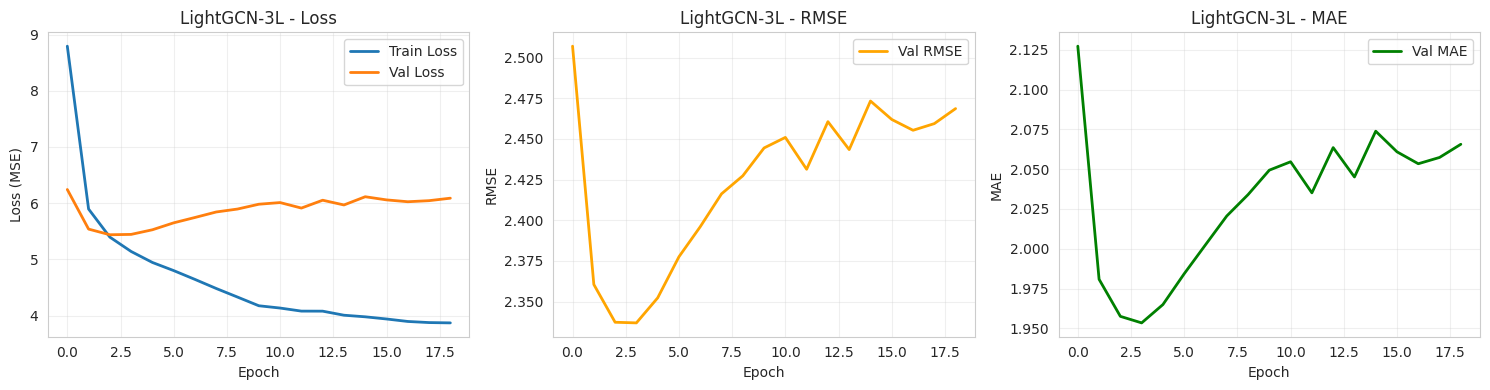

LightGCN with 4 layers

🚀 Training LightGCN
   Learning rate: 0.001
   Weight decay: 1e-05
   Epochs: 50
   Model parameters: 707,265
Epoch 5/50:
  Train Loss: 4.9767
  Val Loss: 5.4591, RMSE: 2.3392, MAE: 1.9532
Epoch 10/50:
  Train Loss: 4.2801
  Val Loss: 5.8916, RMSE: 2.4282, MAE: 2.0356
Epoch 15/50:
  Train Loss: 4.0021
  Val Loss: 6.0926, RMSE: 2.4707, MAE: 2.0739
Early stopping at epoch 19

✓ Training completed in 20.19s
  Best RMSE: 2.3316


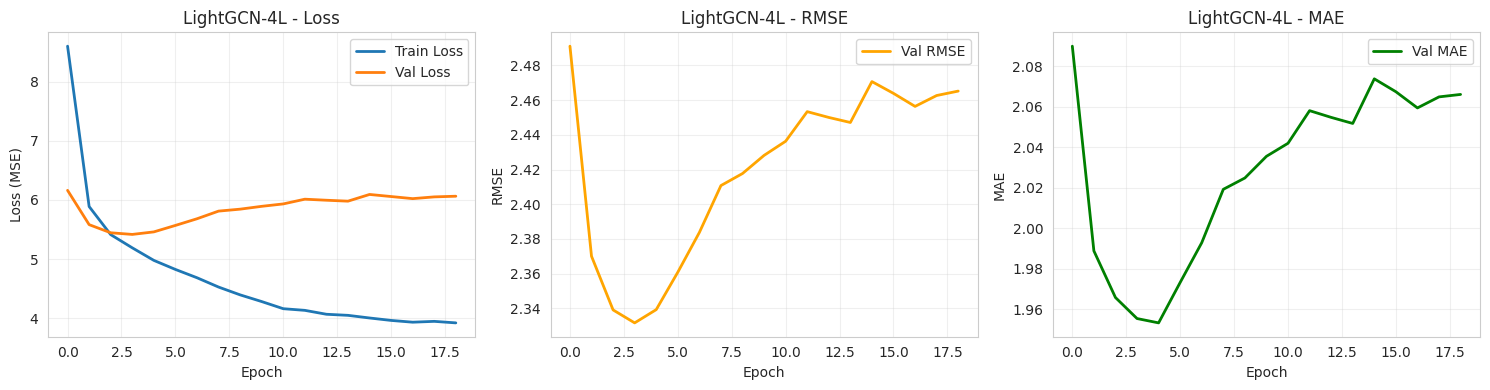

Standard GCN

🚀 Training LightGCN
   Learning rate: 0.0005
   Weight decay: 1e-05
   Epochs: 50
   Model parameters: 740,353
Epoch 5/50:
  Train Loss: 5.3506
  Val Loss: 5.2935, RMSE: 2.3046, MAE: 1.9193
Epoch 10/50:
  Train Loss: 5.0951
  Val Loss: 5.2236, RMSE: 2.2883, MAE: 1.8984
Epoch 15/50:
  Train Loss: 5.0304
  Val Loss: 5.3042, RMSE: 2.3026, MAE: 1.8970
Epoch 20/50:
  Train Loss: 4.9513
  Val Loss: 5.2632, RMSE: 2.2942, MAE: 1.9044
Early stopping at epoch 24

✓ Training completed in 27.81s
  Best RMSE: 2.2835


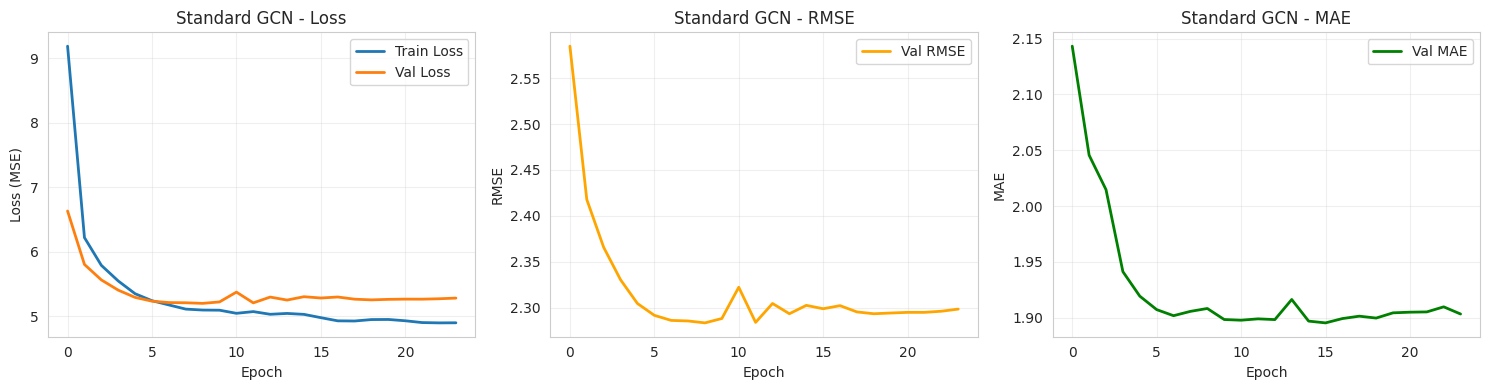


FINAL RESULTS
                  rmse       mae  training_time  parameters
LightGCN-2L   2.327959  2.032603      29.498073    707265.0
LightGCN-3L   2.336852  2.065644      33.657205    707265.0
LightGCN-4L   2.331594  2.066155      20.190023    707265.0
Standard GCN  2.283488  1.903327      27.810932    740353.0


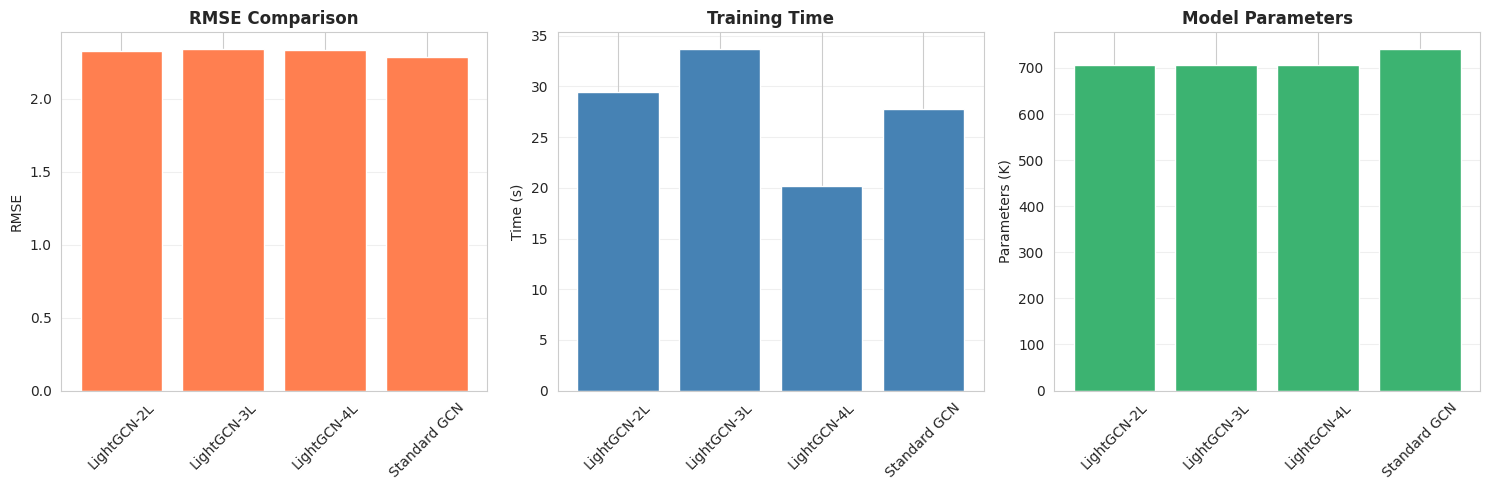


✓ Comparison complete!

Best model: Standard GCN


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader

# =====================================================
# 1. LightGCN IMPLEMENTATION
# =====================================================

class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer - Simplified GCN without transformations"""

    def __init__(self, **kwargs):
        super().__init__(aggr='add', **kwargs)

    def forward(self, x, edge_index):
        # Compute normalization
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Propagate
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


class LightGCNRecommender(nn.Module):


    def __init__(self, n_users, n_books, embedding_dim=64, n_layers=3, alpha=None):
        super().__init__()

        self.n_users = n_users
        self.n_books = n_books
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers

        # Layer combination weights (if None, use uniform)
        if alpha is None:
            self.alpha = torch.ones(n_layers + 1) / (n_layers + 1)
        else:
            self.alpha = torch.tensor(alpha)

        # Embeddings only (no weight matrices!)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)

        # Xavier initialization with smaller gain
        nn.init.xavier_uniform_(self.user_embedding.weight, gain=0.5)
        nn.init.xavier_uniform_(self.book_embedding.weight, gain=0.5)

        # LightGCN convolution (no learnable parameters)
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])

        # Predictor (simple)
        self.predictor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        # Initialize predictor
        for m in self.predictor.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, user_ids, book_ids, edge_index):
        # Get all embeddings
        all_users_emb = self.user_embedding.weight
        all_books_emb = self.book_embedding.weight

        # Concatenate user and book embeddings
        x = torch.cat([all_users_emb, all_books_emb], dim=0)

        # Store embeddings at each layer
        embeddings = [x]

        # LightGCN propagation (no activation, no transformation)
        for conv in self.convs:
            x = conv(x, edge_index)
            embeddings.append(x)

        # Layer combination: weighted sum of all layers
        final_embedding = torch.zeros_like(embeddings[0])
        for i, emb in enumerate(embeddings):
            final_embedding += self.alpha[i] * emb

        # Extract user and book embeddings
        user_final = final_embedding[user_ids]
        book_final = final_embedding[book_ids + self.n_users]

        # Predict rating
        combined = torch.cat([user_final, book_final], dim=1)
        return self.predictor(combined).squeeze()

    def get_embeddings(self, edge_index):
        """Get final user and book embeddings after propagation"""
        all_users_emb = self.user_embedding.weight
        all_books_emb = self.book_embedding.weight
        x = torch.cat([all_users_emb, all_books_emb], dim=0)

        embeddings = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            embeddings.append(x)

        final_embedding = torch.zeros_like(embeddings[0])
        for i, emb in enumerate(embeddings):
            final_embedding += self.alpha[i] * emb

        user_embeddings = final_embedding[:self.n_users]
        book_embeddings = final_embedding[self.n_users:]

        return user_embeddings, book_embeddings


# =====================================================
# 2. GRAPH BUILDER
# =====================================================

class GraphBuilder:
    """Construit un graphe biparti utilisateur-livre"""

    def __init__(self, df):
        self.df = df
        self.user_mapping = {user: idx for idx, user in enumerate(df['user_id'].unique())}
        self.book_mapping = {book: idx for idx, book in enumerate(df['book_id'].unique())}
        self.n_users = len(self.user_mapping)
        self.n_books = len(self.book_mapping)

        print(f"Nombre d'utilisateurs: {self.n_users}")
        print(f"Nombre de livres: {self.n_books}")
        print(f"Nombre d'interactions: {len(df)}")

    def build_edge_index(self):
        """Construit l'edge_index pour un graphe biparti"""
        users = torch.tensor([self.user_mapping[u] for u in self.df['user_id']], dtype=torch.long)
        books = torch.tensor([self.book_mapping[b] for b in self.df['book_id']], dtype=torch.long)

        # Offset pour les livres
        books_offset = books + self.n_users

        # Arêtes bidirectionnelles
        edge_index_forward = torch.stack([users, books_offset], dim=0)
        edge_index_backward = torch.stack([books_offset, users], dim=0)
        edge_index = torch.cat([edge_index_forward, edge_index_backward], dim=1)

        return edge_index


# =====================================================
# 3. DATASET ET DATALOADER
# =====================================================

class ReviewDataset(Dataset):
    def __init__(self, df, user_mapping, book_mapping):
        self.user_ids = torch.tensor([user_mapping[u] for u in df['user_id'].values], dtype=torch.long)
        self.book_ids = torch.tensor([book_mapping[b] for b in df['book_id'].values], dtype=torch.long)
        self.targets = torch.tensor(df['final_score'].values, dtype=torch.float)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.book_ids[idx], self.targets[idx]


def create_dataloaders(train_df, test_df, builder, batch_size=1024):
    train_dataset = ReviewDataset(train_df, builder.user_mapping, builder.book_mapping)
    test_dataset = ReviewDataset(test_df, builder.user_mapping, builder.book_mapping)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader


# =====================================================
# 4. TRAINER
# =====================================================

class LightGCNTrainer:
    """Trainer pour LightGCN"""

    def __init__(self, model, edge_index, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.edge_index = edge_index.to(device)
        self.train_losses = []
        self.val_losses = []
        self.val_rmses = []
        self.val_maes = []
        self.training_time = 0

    def train_epoch(self, train_loader, optimizer, criterion):
        self.model.train()
        total_loss = 0
        num_batches = 0

        for user_ids, book_ids, targets in train_loader:
            user_ids = user_ids.to(self.device)
            book_ids = book_ids.to(self.device)
            targets = targets.to(self.device)

            optimizer.zero_grad()
            predictions = self.model(user_ids, book_ids, self.edge_index)

            if torch.isnan(predictions).any():
                print(f"WARNING: NaN in predictions, skipping batch")
                continue

            loss = criterion(predictions, targets)

            if torch.isnan(loss):
                print(f"WARNING: NaN loss, skipping batch")
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        return total_loss / max(num_batches, 1)

    def evaluate(self, val_loader, criterion):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_targets = []
        num_batches = 0

        with torch.no_grad():
            for user_ids, book_ids, targets in val_loader:
                user_ids = user_ids.to(self.device)
                book_ids = book_ids.to(self.device)
                targets = targets.to(self.device)

                predictions = self.model(user_ids, book_ids, self.edge_index)

                if torch.isnan(predictions).any():
                    predictions = torch.nan_to_num(predictions, nan=targets.mean().item())

                loss = criterion(predictions, targets)

                total_loss += loss.item()
                all_preds.extend(predictions.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                num_batches += 1

        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        if np.isnan(all_preds).any():
            all_preds = np.nan_to_num(all_preds, nan=np.nanmean(all_preds))

        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        mae = mean_absolute_error(all_targets, all_preds)

        return total_loss / num_batches, rmse, mae, all_preds, all_targets

    def train(self, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        criterion = nn.MSELoss()

        best_rmse = float('inf')
        patience = 15
        patience_counter = 0

        start_time = time.time()

        print(f"\n🚀 Training LightGCN")
        print(f"   Learning rate: {lr}")
        print(f"   Weight decay: {weight_decay}")
        print(f"   Epochs: {epochs}")
        print(f"   Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader, optimizer, criterion)

            if np.isnan(train_loss) or np.isinf(train_loss):
                print(f"ERROR: Invalid train loss at epoch {epoch+1}")
                break

            val_loss, rmse, mae, _, _ = self.evaluate(val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_rmses.append(rmse)
            self.val_maes.append(mae)

            scheduler.step(val_loss)

            if (epoch + 1) % 5 == 0:
                print(f'Epoch {epoch+1}/{epochs}:')
                print(f'  Train Loss: {train_loss:.4f}')
                print(f'  Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

            if rmse < best_rmse:
                best_rmse = rmse
                patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    self.model.load_state_dict(self.best_model_state)
                    break

        self.training_time = time.time() - start_time
        print(f'\n✓ Training completed in {self.training_time:.2f}s')
        print(f'  Best RMSE: {best_rmse:.4f}')

        return best_rmse, mae

    def plot_learning_curves(self, title="LightGCN"):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        axes[0].plot(self.train_losses, label='Train Loss', linewidth=2)
        axes[0].plot(self.val_losses, label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss (MSE)')
        axes[0].set_title(f'{title} - Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(self.val_rmses, label='Val RMSE', color='orange', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('RMSE')
        axes[1].set_title(f'{title} - RMSE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        axes[2].plot(self.val_maes, label='Val MAE', color='green', linewidth=2)
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MAE')
        axes[2].set_title(f'{title} - MAE')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# =====================================================
# 5. COMPARISON WITH OTHER MODELS
# =====================================================

class StandardGCNRecommender(nn.Module):
    """Standard GCN pour comparaison"""

    def __init__(self, n_users, n_books, embedding_dim=64, hidden_dim=128):
        super().__init__()
        self.n_users = n_users

        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight, gain=0.5)
        nn.init.xavier_uniform_(self.book_embedding.weight, gain=0.5)

        from torch_geometric.nn import GCNConv
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, embedding_dim)

        self.predictor = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, user_ids, book_ids, edge_index):
        x = torch.cat([self.user_embedding.weight, self.book_embedding.weight], dim=0)

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)

        user_final = x[user_ids]
        book_final = x[book_ids + self.n_users]

        combined = torch.cat([user_final, book_final], dim=1)
        return self.predictor(combined).squeeze()


def compare_models(train_path='train_set.csv', test_path='test_set.csv'):
    """Compare LightGCN with standard GCN"""

    print("="*70)
    print("COMPARISON: LightGCN vs Standard GCN")
    print("="*70)

    # Load data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    df_combined = pd.concat([train_df, test_df], ignore_index=True)

    print(f"\nData: {len(train_df)} train, {len(test_df)} test")

    # Build graph
    builder = GraphBuilder(df_combined)
    edge_index = builder.build_edge_index()

    # Create dataloaders
    train_loader, test_loader = create_dataloaders(train_df, test_df, builder, batch_size=1024)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}\n")

    results = {}

    # Test LightGCN with different layer configurations
    for n_layers in [2, 3, 4]:
        print("="*70)
        print(f"LightGCN with {n_layers} layers")
        print("="*70)

        model = LightGCNRecommender(
            n_users=builder.n_users,
            n_books=builder.n_books,
            embedding_dim=64,
            n_layers=n_layers
        )

        trainer = LightGCNTrainer(model, edge_index, device)
        rmse, mae = trainer.train(train_loader, test_loader, epochs=50, lr=0.001)
        trainer.plot_learning_curves(f"LightGCN-{n_layers}L")

        results[f'LightGCN-{n_layers}L'] = {
            'rmse': rmse,
            'mae': mae,
            'training_time': trainer.training_time,
            'parameters': sum(p.numel() for p in model.parameters())
        }

    # Test Standard GCN
    print("="*70)
    print("Standard GCN")
    print("="*70)

    model = StandardGCNRecommender(
        n_users=builder.n_users,
        n_books=builder.n_books,
        embedding_dim=64,
        hidden_dim=128
    )

    trainer = LightGCNTrainer(model, edge_index, device)
    rmse, mae = trainer.train(train_loader, test_loader, epochs=50, lr=0.0005)
    trainer.plot_learning_curves("Standard GCN")

    results['Standard GCN'] = {
        'rmse': rmse,
        'mae': mae,
        'training_time': trainer.training_time,
        'parameters': sum(p.numel() for p in model.parameters())
    }

    # Display results
    print("\n" + "="*70)
    print("FINAL RESULTS")
    print("="*70)

    df_results = pd.DataFrame(results).T
    print(df_results.to_string())

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    model_names = list(results.keys())

    axes[0].bar(model_names, [r['rmse'] for r in results.values()], color='coral')
    axes[0].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].bar(model_names, [r['training_time'] for r in results.values()], color='steelblue')
    axes[1].set_title('Training Time', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Time (s)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')

    axes[2].bar(model_names, [r['parameters']/1000 for r in results.values()], color='mediumseagreen')
    axes[2].set_title('Model Parameters', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Parameters (K)')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return results, builder


# =====================================================
# 6. MAIN
# =====================================================

if __name__ == "__main__":
    # Run comparison
    results, builder = compare_models('train_set.csv', 'test_set.csv')

    print("\n✓ Comparison complete!")
    print(f"\nBest model: {min(results.items(), key=lambda x: x[1]['rmse'])[0]}")